# Flight-Delay Prediction with STGNN 
Inspiration [artical](https://www.ijcai.org/proceedings/2018/0505.pdf)

### you will need to run Kaggle_data_stgnn.ipynb first to get the csv file

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import radians, sin, cos, sqrt, asin

import torch
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, regularizers
import tensorflow as tf


In [4]:
df_gnn = pd.read_csv('../CSV/network_weather_2014.csv')

len(df_gnn)


FileNotFoundError: [Errno 2] No such file or directory: '../CSV/network_weather_2014.csv'

In [ ]:
df_gnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3541995 entries, 0 to 3541994
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         object 
 6   DEP_TIME             object 
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           object 
 10  WHEELS_ON            object 
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         object 
 13  ARR_TIME             object 
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

In [ ]:
n_unique = df_gnn["OP_CARRIER"].nunique(dropna=True)
print(f"Unique OP_CARRIER_FL_NUM values : {n_unique:,}")

Unique OP_CARRIER_FL_NUM values : 14


In [ ]:


# How many distinct flight numbers?
n_unique = df_gnn["OP_CARRIER_FL_NUM"].nunique(dropna=True)
print(f"Unique OP_CARRIER_FL_NUM values : {n_unique:,}")



Unique OP_CARRIER_FL_NUM values : 6,364

Top-10 flight numbers:
 Flight #  Count
       15   3228
       12   2889
      403   2876
       16   2846
      686   2809
        3   2794
      552   2782
      404   2758
      407   2752
        1   2681


In [ ]:


# ────────────────────────────────────────────────────────────
# Making sine cosine time columns
# ────────────────────────────────────────────────────────────
# Minute of day 0-1439
dep_min_of_day = df_gnn["CRS_DEP_HOUR"] * 60 + df_gnn["CRS_DEP_MINUTE"]
arr_min_of_day = df_gnn["CRS_ARR_HOUR"] * 60 + df_gnn["CRS_ARR_MINUTE"]

# ────────────────────────────────────────────────────────────
# 2)  Convert to radians  (2π · fraction of cycle)
# ────────────────────────────────────────────────────────────
dep_angle = 2 * np.pi * dep_min_of_day / (24 * 60)       # 24-hour cycle
arr_angle = 2 * np.pi * arr_min_of_day / (24 * 60)

# ────────────────────────────────────────────────────────────
# 3)  Add sine / cosine columns
# ────────────────────────────────────────────────────────────
df_gnn["dep_time_sin"] = np.sin(dep_angle).astype("float32")
df_gnn["dep_time_cos"] = np.cos(dep_angle).astype("float32")

df_gnn["arr_time_sin"] = np.sin(arr_angle).astype("float32")
df_gnn["arr_time_cos"] = np.cos(arr_angle).astype("float32")


df = df_gnn

In [ ]:
df_gnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3541995 entries, 0 to 3541994
Data columns (total 64 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   OP_CARRIER_FL_NUM    int64  
 3   ORIGIN               object 
 4   DEST                 object 
 5   CRS_DEP_TIME         object 
 6   DEP_TIME             object 
 7   DEP_DELAY            float64
 8   TAXI_OUT             float64
 9   WHEELS_OFF           object 
 10  WHEELS_ON            object 
 11  TAXI_IN              float64
 12  CRS_ARR_TIME         object 
 13  ARR_TIME             object 
 14  ARR_DELAY            float64
 15  CANCELLED            float64
 16  CANCELLATION_CODE    object 
 17  DIVERTED             float64
 18  CRS_ELAPSED_TIME     float64
 19  ACTUAL_ELAPSED_TIME  float64
 20  AIR_TIME             float64
 21  DISTANCE             float64
 22  CARRIER_DELAY        float64
 23  WEATHER_DELAY        float64
 24

In [ ]:
df_gnn.head(10)

FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST CRS_DEP_TIME  \
0  2014-01-01         US               1830    SEA  CLT     00:10:00   
1  2014-01-01         AA               1052    SFO  DFW     00:20:00   
2  2014-01-01         US               1899    SFO  CLT     00:20:00   
3  2014-01-01         UA               1197    SFO  IAH     00:23:00   
4  2014-01-01         DL               1110    PHX  DTW     00:25:00   
5  2014-01-01         UA               1614    LAX  IAH     00:25:00   
6  2014-01-01         UA                357    LAS  IAH     00:29:00   
7  2014-01-01         US                788    SFO  PHL     00:30:00   
8  2014-01-01         US                466    PDX  CLT     00:30:00   
9  2014-01-01         DL               1702    LAS  ATL     00:30:00   

   DEP_TIME  DEP_DELAY  TAXI_OUT WHEELS_OFF  ... arr_dwpt  arr_rhum arr_prcp  \
0  00:04:00       -6.0      15.0   00:19:00  ...     -5.0      75.0      0.0   
1  00:20:00        0.0      15.0   00:35:00  ...     -4.0      55.0      0.0   
2  00:18:00       -2.0      12.0   00:30:00  ...     -5.0      75.0      0.0   
3  00:37:00       14.0      14.0   00:51:00  ...      3.6      79.0      0.0   
4  00:22:00       -3.0      14.0   00:36:00  ...    -12.4      77.0      0.0   
5  00:58:00       33.0      14.0   01:12:00  ...      3.6      79.0      0.0   
6  01:18:00       49.0      10.0   01:28:00  ...      3.6      79.0      0.0   
7  00:23:00       -7.0      17.0   00:40:00  ...    -13.5      52.0      0.0   
8  00:28:00       -2.0      13.0   00:41:00  ...     -5.0      75.0      0.0   
9  00:22:00       -8.0      11.0   00:33:00  ...     -3.1      79.0      0.0   

  arr_wdir  arr_wspd  arr_pres dep_time_sin  dep_time_cos  arr_time_sin  \
0      0.0       0.0    1028.3     0.043619      0.999048      0.863836   
1    160.0      14.8    1023.5     0.087156      0.996195      0.994056   
2      0.0       0.0    1028.3     0.087156      0.996195      0.850352   
3    120.0       7.6    1025.7     0.100188      0.994969      0.999048   
4    260.0       9.4    1027.2     0.108867      0.994056      0.999914   
5    100.0       9.4    1026.2     0.108867      0.994056      0.993068   
6    100.0       9.4    1026.2     0.126199      0.992005      0.979045   
7    210.0       5.4    1029.3     0.130526      0.991445      0.779884   
8      0.0       0.0    1028.3     0.130526      0.991445      0.811574   
9      0.0       0.0    1027.0     0.130526      0.991445      0.956305   

   arr_time_cos  
0     -0.503774  
1      0.108867  
2     -0.526214  
3     -0.043619  
4     -0.013090  
5      0.117537  
6      0.203642  
7     -0.625923  
8     -0.584250  
9     -0.292372  

[10 rows x 64 columns]

## Filtering top 37 airports

In [ ]:
top_10_airports = (
    df_gnn[["ORIGIN", "DEST"]]
      .stack()            # long Series of all endpoints
      .value_counts()
      .head(37)
      .index
      .tolist()
)
print("Top-20 airports:", top_10_airports)
# 2) Keep only flights fully inside that set
# ------------------------------------------------------------------
df_gnn = (
    df_gnn[df_gnn["ORIGIN"].isin(top_10_airports) & df_gnn["DEST"].isin(top_10_airports)]
          .reset_index(drop=True)
)
print("df_gnn rows after filter:", len(df_gnn))

Top-20 airports: ['ATL', 'LAX', 'ORD', 'DFW', 'DEN', 'SFO', 'PHX', 'LAS', 'IAH', 'BOS', 'CLT', 'MCO', 'LGA', 'EWR', 'SEA', 'JFK', 'MSP', 'DTW', 'SAN', 'DCA', 'MDW', 'PHL', 'MIA', 'SLC', 'BWI', 'FLL', 'TPA', 'BNA', 'STL', 'HOU', 'PDX', 'MCI', 'IAD', 'AUS', 'MSY', 'SNA', 'RDU']
df_gnn rows after filter: 2782343


In [ ]:
df_gnn[:10]

FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST CRS_DEP_TIME  \
0  2014-01-01         US               1830    SEA  CLT     00:10:00   
1  2014-01-01         AA               1052    SFO  DFW     00:20:00   
2  2014-01-01         US               1899    SFO  CLT     00:20:00   
3  2014-01-01         UA               1197    SFO  IAH     00:23:00   
4  2014-01-01         DL               1110    PHX  DTW     00:25:00   
5  2014-01-01         UA               1614    LAX  IAH     00:25:00   
6  2014-01-01         UA                357    LAS  IAH     00:29:00   
7  2014-01-01         US                788    SFO  PHL     00:30:00   
8  2014-01-01         US                466    PDX  CLT     00:30:00   
9  2014-01-01         DL               1702    LAS  ATL     00:30:00   

   DEP_TIME  DEP_DELAY  TAXI_OUT WHEELS_OFF  ... arr_dwpt  arr_rhum arr_prcp  \
0  00:04:00       -6.0      15.0   00:19:00  ...     -5.0      75.0      0.0   
1  00:20:00        0.0      15.0   00:35:00  ...     -4.0      55.0      0.0   
2  00:18:00       -2.0      12.0   00:30:00  ...     -5.0      75.0      0.0   
3  00:37:00       14.0      14.0   00:51:00  ...      3.6      79.0      0.0   
4  00:22:00       -3.0      14.0   00:36:00  ...    -12.4      77.0      0.0   
5  00:58:00       33.0      14.0   01:12:00  ...      3.6      79.0      0.0   
6  01:18:00       49.0      10.0   01:28:00  ...      3.6      79.0      0.0   
7  00:23:00       -7.0      17.0   00:40:00  ...    -13.5      52.0      0.0   
8  00:28:00       -2.0      13.0   00:41:00  ...     -5.0      75.0      0.0   
9  00:22:00       -8.0      11.0   00:33:00  ...     -3.1      79.0      0.0   

  arr_wdir  arr_wspd  arr_pres dep_time_sin  dep_time_cos  arr_time_sin  \
0      0.0       0.0    1028.3     0.043619      0.999048      0.863836   
1    160.0      14.8    1023.5     0.087156      0.996195      0.994056   
2      0.0       0.0    1028.3     0.087156      0.996195      0.850352   
3    120.0       7.6    1025.7     0.100188      0.994969      0.999048   
4    260.0       9.4    1027.2     0.108867      0.994056      0.999914   
5    100.0       9.4    1026.2     0.108867      0.994056      0.993068   
6    100.0       9.4    1026.2     0.126199      0.992005      0.979045   
7    210.0       5.4    1029.3     0.130526      0.991445      0.779884   
8      0.0       0.0    1028.3     0.130526      0.991445      0.811574   
9      0.0       0.0    1027.0     0.130526      0.991445      0.956305   

   arr_time_cos  
0     -0.503774  
1      0.108867  
2     -0.526214  
3     -0.043619  
4     -0.013090  
5      0.117537  
6      0.203642  
7     -0.625923  
8     -0.584250  
9     -0.292372  

[10 rows x 64 columns]

option to drop some airports that were missing couple of weather data

In [ ]:
""" # airports to exclude completely
bad_airports = {"EWR", "HNL", "HOU", "LGA"}

# keep only flights whose ORIGIN *and* DEST are not in the bad list
mask = ~df_gnn[["ORIGIN", "DEST"]].isin(bad_airports).any(axis=1)
rows_before = len(df_gnn)

df_gnn = df_gnn[mask].reset_index(drop=True)

print(f"Dropped {rows_before - len(df_gnn):,} rows "
      f"({rows_before:,} ➜ {len(df_gnn):,})")
 """

' # airports to exclude completely\nbad_airports = {"EWR", "HNL", "HOU", "LGA"}\n\n# keep only flights whose ORIGIN *and* DEST are not in the bad list\nmask = ~df_gnn[["ORIGIN", "DEST"]].isin(bad_airports).any(axis=1)\nrows_before = len(df_gnn)\n\ndf_gnn = df_gnn[mask].reset_index(drop=True)\n\nprint(f"Dropped {rows_before - len(df_gnn):,} rows "\n      f"({rows_before:,} ➜ {len(df_gnn):,})")\n '

In [ ]:
len(df_gnn)

2782343

drop column: "unnamed" and doing to_numeric and to_datetime

In [ ]:
# ───────────────────────────────────────────────
# 1.  Basic column cleanup
# ───────────────────────────────────────────────
# a) Drop placeholder & exact duplicates
df_gnn = df_gnn.drop(columns=["Unnamed: 27"], errors="ignore").copy()

# b) Uniform dtypes for key numerics (coerce bad strings → NaN)
numeric_cols = [
    "CRS_DEP_TIME","CRS_ARR_TIME","CRS_ELAPSED_TIME","DISTANCE",
    "ARR_DELAY","DEP_DELAY","TAXI_OUT","TAXI_IN","AIR_TIME",
]
for col in numeric_cols:
    df_gnn[col] = pd.to_numeric(df_gnn[col], errors="coerce")

# c) Parse FL_DATE
df_gnn["FL_DATE"] = pd.to_datetime(df_gnn["FL_DATE"], errors="coerce")

df_gnn["CRS_DEP_DATETIME"] = pd.to_datetime(df_gnn["CRS_DEP_DATETIME"], errors="coerce")
df_gnn["CRS_ARR_DATETIME"] = pd.to_datetime(df_gnn["CRS_ARR_DATETIME"], errors="coerce")

In [ ]:
len(df_gnn)

2782343

In [ ]:
#  Drop rows with critical missing data

critical = ["FL_DATE", "OP_CARRIER", "OP_CARRIER_FL_NUM","ORIGIN", "DEST",
            "ARR_DELAY","DEP_DELAY"]                                # your label
df_gnn = df_gnn.dropna(subset=critical)
len(df_gnn)

2727776

In [ ]:
df_gnn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2727776 entries, 0 to 2782342
Data columns (total 64 columns):
 #   Column               Dtype              
---  ------               -----              
 0   FL_DATE              datetime64[ns]     
 1   OP_CARRIER           object             
 2   OP_CARRIER_FL_NUM    int64              
 3   ORIGIN               object             
 4   DEST                 object             
 5   CRS_DEP_TIME         float64            
 6   DEP_TIME             object             
 7   DEP_DELAY            float64            
 8   TAXI_OUT             float64            
 9   WHEELS_OFF           object             
 10  WHEELS_ON            object             
 11  TAXI_IN              float64            
 12  CRS_ARR_TIME         float64            
 13  ARR_TIME             object             
 14  ARR_DELAY            float64            
 15  CANCELLED            float64            
 16  CANCELLATION_CODE    object             
 17  DIVERTED     

In [ ]:

#  Encode the categorical IDs (airline / airport)
#     – One-hot on airports 


for col in ["ORIGIN", "DEST","OP_CARRIER"]:
    df_gnn[col] = df_gnn[col].astype("category")        
    df_gnn[f"{col}_ID"] = df_gnn[col].cat.codes.astype("int16")





In [ ]:
df_gnn.head(40)

FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  CRS_DEP_TIME  \
0  2014-01-01         US               1830    SEA  CLT           NaN   
1  2014-01-01         AA               1052    SFO  DFW           NaN   
2  2014-01-01         US               1899    SFO  CLT           NaN   
3  2014-01-01         UA               1197    SFO  IAH           NaN   
4  2014-01-01         DL               1110    PHX  DTW           NaN   
5  2014-01-01         UA               1614    LAX  IAH           NaN   
6  2014-01-01         UA                357    LAS  IAH           NaN   
7  2014-01-01         US                788    SFO  PHL           NaN   
8  2014-01-01         US                466    PDX  CLT           NaN   
9  2014-01-01         DL               1702    LAS  ATL           NaN   
10 2014-01-01         US               1965    LAX  CLT           NaN   
11 2014-01-01         DL               2324    SLC  ATL           NaN   
12 2014-01-01         B6                 98    DEN  JFK           NaN   
14 2014-01-01         US                792    LAX  PHL           NaN   
15 2014-01-01         DL               1422    DEN  ATL           NaN   
16 2014-01-01         US                680    PHX  DCA           NaN   
17 2014-01-01         UA                269    LAX  IAH           NaN   
18 2014-01-01         AA               2406    LAX  DFW           NaN   
19 2014-01-01         US               1960    LAS  CLT           NaN   
20 2014-01-01         US               1974    LAX  CLT           NaN   
21 2014-01-01         US               1910    PHX  CLT           NaN   
23 2014-01-01         UA                442    SLC  IAH           NaN   
25 2014-01-01         US                452    ORD  PHX           NaN   
27 2014-01-01         UA               1500    ORD  IAH           NaN   
29 2014-01-01         UA               1014    EWR  IAH           NaN   
30 2014-01-01         UA               1198    BOS  ORD           NaN   
31 2014-01-01         UA               1576    SEA  DEN           NaN   
32 2014-01-01         US                460    SEA  PHX           NaN   
34 2014-01-01         US                649    PDX  PHX           NaN   
35 2014-01-01         DL                850    TPA  ATL           NaN   
36 2014-01-01         B6               2228    MCO  EWR           NaN   
37 2014-01-01         UA                215    MIA  EWR           NaN   
38 2014-01-01         DL               1991    MSP  ATL           NaN   
39 2014-01-01         OO               4968    AUS  IAH           NaN   
41 2014-01-01         AA               1429    BOS  MIA           NaN   
42 2014-01-01         UA                420    PHL  IAH           NaN   
43 2014-01-01         UA                229    PDX  IAH           NaN   
44 2014-01-01         EV               6022    BNA  ORD           NaN   
45 2014-01-01         UA                428    LAX  IAH           NaN   
46 2014-01-01         OO               6196    MCI  SFO           NaN   

    DEP_TIME  DEP_DELAY  TAXI_OUT WHEELS_OFF  ... arr_wdir  arr_wspd  \
0   00:04:00      -6.00      15.0   00:19:00  ...      0.0       0.0   
1   00:20:00       0.01      15.0   00:35:00  ...    160.0      14.8   
2   00:18:00      -2.00      12.0   00:30:00  ...      0.0       0.0   
3   00:37:00      14.00      14.0   00:51:00  ...    120.0       7.6   
4   00:22:00      -3.00      14.0   00:36:00  ...    260.0       9.4   
5   00:58:00      33.00      14.0   01:12:00  ...    100.0       9.4   
6   01:18:00      49.00      10.0   01:28:00  ...    100.0       9.4   
7   00:23:00      -7.00      17.0   00:40:00  ...    210.0       5.4   
8   00:28:00      -2.00      13.0   00:41:00  ...      0.0       0.0   
9   00:22:00      -8.00      11.0   00:33:00  ...      0.0       0.0   
10  00:30:00      -5.00      25.0   00:55:00  ...      0.0       0.0   
11  00:34:00      -6.00      11.0   00:45:00  ...      0.0       0.0   
12  01:01:00      18.00      10.0   01:11:00  ...    280.0      25.9   
14  

In [ ]:
df_gnn.isna().sum()


FL_DATE              0
OP_CARRIER           0
OP_CARRIER_FL_NUM    0
ORIGIN               0
DEST                 0
                    ..
arr_time_sin         0
arr_time_cos         0
ORIGIN_ID            0
DEST_ID              0
OP_CARRIER_ID        0
Length: 67, dtype: int64

In [ ]:
df_gnn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2727776 entries, 0 to 2782342
Data columns (total 67 columns):
 #   Column               Dtype              
---  ------               -----              
 0   FL_DATE              datetime64[ns]     
 1   OP_CARRIER           category           
 2   OP_CARRIER_FL_NUM    int64              
 3   ORIGIN               category           
 4   DEST                 category           
 5   CRS_DEP_TIME         float64            
 6   DEP_TIME             object             
 7   DEP_DELAY            float64            
 8   TAXI_OUT             float64            
 9   WHEELS_OFF           object             
 10  WHEELS_ON            object             
 11  TAXI_IN              float64            
 12  CRS_ARR_TIME         float64            
 13  ARR_TIME             object             
 14  ARR_DELAY            float64            
 15  CANCELLED            float64            
 16  CANCELLATION_CODE    object             
 17  DIVERTED     

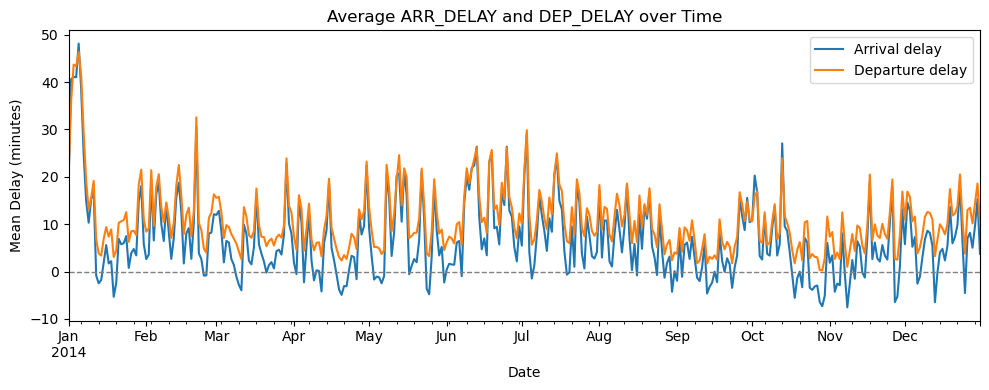

In [ ]:
import matplotlib.pyplot as plt

# --- compute daily means -------------------------------------------------
daily_means = (
    df_gnn
    .groupby("FL_DATE")[["ARR_DELAY", "DEP_DELAY"]]
    .mean()
)

# --- plot ---------------------------------------------------------------
plt.figure(figsize=(10, 4))

daily_means["ARR_DELAY"].plot(label="Arrival delay")   # default colour
daily_means["DEP_DELAY"].plot(label="Departure delay") # second default colour
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)

plt.title("Average ARR_DELAY and DEP_DELAY over Time")
plt.xlabel("Date")
plt.ylabel("Mean Delay (minutes)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(df_gnn[['ARR_DELAY', 'DEP_DELAY']].describe())


          ARR_DELAY     DEP_DELAY
count  2.727776e+06  2.727776e+06
mean   6.837241e+00  1.088560e+01
std    3.917452e+01  3.644464e+01
min   -1.120000e+02 -1.120000e+02
25%   -1.200000e+01 -4.000000e+00
50%   -3.000000e+00 -1.000000e+00
75%    1.100000e+01  1.000000e+01
max    2.444000e+03  2.402000e+03


In [ ]:
n_zero_arr_delay = (df_gnn["ARR_DELAY"] == 0).sum()
print(f"Rows with ARR_DELAY == 0 : {n_zero_arr_delay:,}")


Rows with ARR_DELAY == 0 : 61,392


We make all real 0 delays equal to 0.01

In [ ]:
mask = df_gnn["ARR_DELAY"] == 0
df_gnn.loc[mask, "ARR_DELAY"] = 0.01
mask = df_gnn["DEP_DELAY"] == 0
df_gnn.loc[mask, "DEP_DELAY"] = 0.01

In [ ]:
print("Zeros remaining :", (df_gnn["ARR_DELAY"] == 0).sum())
print("0.01 values      :", (df_gnn["ARR_DELAY"] == 0.01).sum())


Zeros remaining : 0
0.01 values      : 61392


cutting 2.5% upper and lower bounds

In [ ]:
# Calculate bounds
arr_lo = df_gnn['ARR_DELAY'].quantile(0.025)
arr_hi = df_gnn['ARR_DELAY'].quantile(0.975)
dep_lo = df_gnn['DEP_DELAY'].quantile(0.025)
dep_hi = df_gnn['DEP_DELAY'].quantile(0.975)

# Filter data
df_trimmed = df_gnn[
    (df_gnn['ARR_DELAY'].between(arr_lo, arr_hi)) &
    (df_gnn['DEP_DELAY'].between(dep_lo, dep_hi))
]

# Check new stats
print(df_trimmed[['ARR_DELAY', 'DEP_DELAY']].describe())
df_gnn = df_trimmed

          ARR_DELAY     DEP_DELAY
count  2.560324e+06  2.560324e+06
mean   3.117394e+00  6.877766e+00
std    2.260826e+01  1.947195e+01
min   -2.800000e+01 -1.000000e+01
25%   -1.100000e+01 -4.000000e+00
50%   -3.000000e+00 -1.000000e+00
75%    1.000000e+01  9.000000e+00
max    1.100000e+02  1.080000e+02


In [ ]:


# ---  daily means-
daily_means = (
    df_gnn
    .groupby("FL_DATE")[["ARR_DELAY", "DEP_DELAY"]]
    .mean()
)

# --- plot ---------------------------------------------------------------
plt.figure(figsize=(10, 4))

daily_means["ARR_DELAY"].plot(label="Arrival delay" color="steelblue")   # default colour
daily_means["DEP_DELAY"].plot(label="Departure delay") # second default colour
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)

plt.title("Average ARR_DELAY and DEP_DELAY over Time")
plt.xlabel("Date")
plt.ylabel("Mean Delay (minutes)")
plt.legend()
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3056389407.py, line 11)

ARR_DELAY outliers: 184536 (values < -42.5 or > 41.5)
DEP_DELAY outliers: 285715 (values < -23.5 or > 28.5)


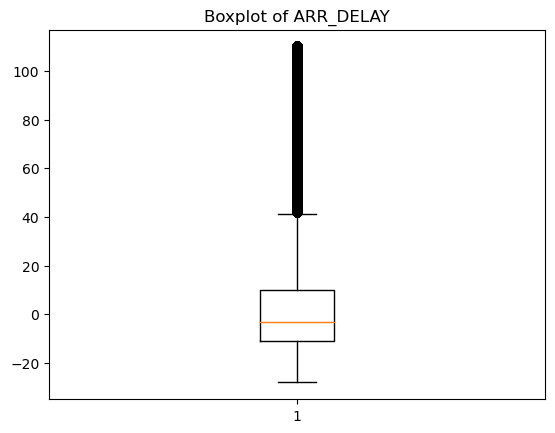

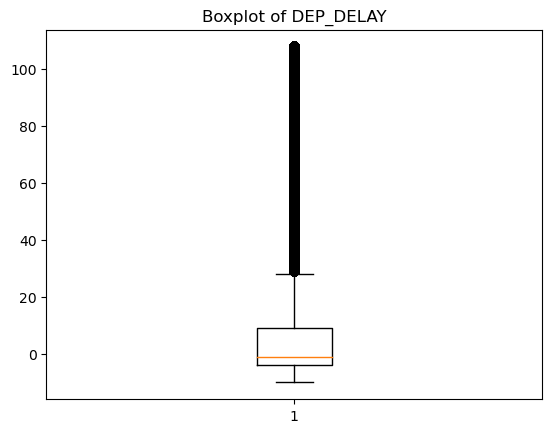

In [ ]:
import pandas as pd

# Define a helper function to find outliers based on IQR
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Find outliers for ARR_DELAY and DEP_DELAY
arr_outliers, arr_lb, arr_ub = find_outliers_iqr(df_gnn, 'ARR_DELAY')
dep_outliers, dep_lb, dep_ub = find_outliers_iqr(df_gnn, 'DEP_DELAY')

# Print quick summaries
print(f"ARR_DELAY outliers: {len(arr_outliers)} (values < {arr_lb:.1f} or > {arr_ub:.1f})")
print(f"DEP_DELAY outliers: {len(dep_outliers)} (values < {dep_lb:.1f} or > {dep_ub:.1f})")
# Display top 10 outliers
import matplotlib.pyplot as plt

plt.boxplot(df_gnn[['ARR_DELAY']].dropna())
plt.title('Boxplot of ARR_DELAY')
plt.show()

plt.boxplot(df_gnn[['DEP_DELAY']].dropna())
plt.title('Boxplot of DEP_DELAY')
plt.show()





In [ ]:
# Define Nodes
airports = pd.Index(sorted(set(df_gnn["ORIGIN"]) | set(df_gnn["DEST"])))
airport_to_idx = {iata: i for i, iata in enumerate(airports)}

# Define edges (flights)
df_filtered = df_gnn[(df_gnn['ORIGIN'].isin(airports)) & (df_gnn['DEST'].isin(airports))]

# Edges: from ORIGIN to DEST
edge_index = torch.tensor([
    df_filtered['ORIGIN'].map(airport_to_idx).values,
    df_filtered['DEST'].map(airport_to_idx).values
], dtype=torch.long)



In [ ]:
# Haversine function
def haversine(coords1, coords2):
    lon1, lat1 = coords1
    lon2, lat2 = coords2
    R = 6371  # Radius of earth in kilometers

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

In [ ]:
def distance_adjacency(airports, airport_dict, threshold=1000):
    n = len(airports)
    D = np.zeros((n, n))

    for i, airport1 in enumerate(airports):
        for j, airport2 in enumerate(airports):
            coords1 = (airport_dict[airport1]["longitude"], airport_dict[airport1]["latitude"])
            coords2 = (airport_dict[airport2]["longitude"], airport_dict[airport2]["latitude"])
            dist = haversine(coords1, coords2)
            D[i, j] = dist

    st_dev = np.std(D)
    weights = np.where(D < threshold, np.exp(-(D ** 2) / st_dev ** 2), 0)
    np.fill_diagonal(weights, 0)
    return weights

In [ ]:
# ------------------------------------------------------------------
# 0.  Load airport metadata once
# ------------------------------------------------------------------
meta_df = pd.read_csv("../../Data/Airports/airports.csv").set_index("iata_code")

# ------------------------------------------------------------------
# 1.  Keep only airports present in metadata
# ------------------------------------------------------------------
missing = set(airports) - set(meta_df.index)
if missing:
    print(f"Dropping {len(missing)} airports with no metadata: {sorted(missing)[:10]}…")

#airports = [a for a in airports if a in meta_df.index]          # filtered list
airport_to_idx = {iata: i for i, iata in enumerate(airports)}   # remap

# ------------------------------------------------------------------
# 2.  Re-index metadata and build node features
# ------------------------------------------------------------------
node_df = meta_df.loc[airports]  # guaranteed to succeed now
node_features = node_df[[
    "ident",         # or drop if not needed in the model
    "latitude_deg",
    "longitude_deg",
    "elevation_ft",
]].copy()

print(f"Final graph has {len(airports)} nodes")


Final graph has 37 nodes


In [ ]:
airport_dict = {
    iata: {
        "latitude": row["latitude_deg"],
        "longitude": row["longitude_deg"]
    }
    for iata, row in node_features.iterrows()
}

A_spatial = distance_adjacency(airports, airport_dict)
A_spatial.shape

(37, 37)

# Preparing Hourly Graph Tensors for the Flight-Delay GNN
Before a Graph Neural Network (GNN) can effectively predict flight delays, raw flight logs must be transformed into structured data tensors. Spatio-temporal GNNs can't directly learn from irregular, unevenly timed data—they require standardized, numeric snapshots of each airport's status and how airports interact over consistent hourly intervals

This preprocessing pipeline systematically converts the raw flight log data into three essential tensors:
| Tensor | Meaning | Why the GNN needs it |
| ------ | ----------------- | -------------------- |
| **X**  | Hourly features per airport | Node features for spatial-temporal modeling |
| **A**  | Hourly airport connectivity matrices | Defines delay propagation paths |
| **Y**  | Future flight delays | Prediction targets |


## Train/test split

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Build hourly time bins + train/test split
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

df = df_gnn.copy()

# ------------------------------------------------------------------  
# 1)  Make sure FL_DATE is a real date  
# ------------------------------------------------------------------  
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], errors="coerce")

# ------------------------------------------------------------------  
# 2)  Combine FL_DATE + CRS_DEP_TIME ➜ CRS_DEP_DATETIME  
#     CRS_DEP_TIME is usually an int hhmm (e.g.  530 for 05:30).  
# ------------------------------------------------------------------  

def make_dep_datetime(row):
    """
    Combine FL_DATE ('YYYY-MM-DD') with CRS_DEP_TIME (hhmm or string) → Timestamp.
    Handles missing / malformed times by returning NaT.
    """
    t = row["CRS_DEP_TIME"]
    if pd.isna(t):
        return pd.NaT

    # zero-pad, keep last 4 chars, split hh / mm
    t = str(int(t)).zfill(4)[-4:]
    hh, mm = int(t[:2]), int(t[2:])

    # 2400 → 00:00 next day (rare)
    if hh == 24:
        hh = 0
        row_date = row["FL_DATE"] + pd.Timedelta(days=1)
    else:
        row_date = row["FL_DATE"]

    return pd.Timestamp(row_date) + pd.Timedelta(hours=hh, minutes=mm)

#df["CRS_DEP_DATETIME"] = df.apply(make_dep_datetime, axis=1)
df = df.dropna(subset=["CRS_DEP_DATETIME"])        # remove bad rows
df["time_bin"] = df["CRS_DEP_DATETIME"].dt.floor("H")

# ------------------------------------------------------------------  
# 3)  Train / test split (temporal hold-out)  
#     → 80 % of unique FL_DATEs for training, 20 % for testing.  
# ------------------------------------------------------------------  
unique_dates = np.sort(df["FL_DATE"].unique())
split_idx    = int(len(unique_dates) * 0.80)

train_dates  = unique_dates[:split_idx]
test_dates   = unique_dates[split_idx:]

df_train = df[df["FL_DATE"].isin(train_dates)].copy()
df_test  = df[df["FL_DATE"].isin(test_dates)].copy()

print(f"# Unique dates total: {len(unique_dates):,}")
print(f"# Train samples      : {len(df_train):,}")
print(f"# Test  samples      : {len(df_test):,}")



# Unique dates total: 365
# Train samples      : 2,058,392
# Test  samples      : 501,932


In [ ]:
df_gnn.head(20)

FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  CRS_DEP_TIME  \
0  2014-01-01         US               1830    SEA  CLT           NaN   
1  2014-01-01         AA               1052    SFO  DFW           NaN   
2  2014-01-01         US               1899    SFO  CLT           NaN   
3  2014-01-01         UA               1197    SFO  IAH           NaN   
4  2014-01-01         DL               1110    PHX  DTW           NaN   
5  2014-01-01         UA               1614    LAX  IAH           NaN   
6  2014-01-01         UA                357    LAS  IAH           NaN   
7  2014-01-01         US                788    SFO  PHL           NaN   
8  2014-01-01         US                466    PDX  CLT           NaN   
9  2014-01-01         DL               1702    LAS  ATL           NaN   
10 2014-01-01         US               1965    LAX  CLT           NaN   
11 2014-01-01         DL               2324    SLC  ATL           NaN   
12 2014-01-01         B6                 98    DEN  JFK           NaN   
14 2014-01-01         US                792    LAX  PHL           NaN   
15 2014-01-01         DL               1422    DEN  ATL           NaN   
16 2014-01-01         US                680    PHX  DCA           NaN   
17 2014-01-01         UA                269    LAX  IAH           NaN   
18 2014-01-01         AA               2406    LAX  DFW           NaN   
19 2014-01-01         US               1960    LAS  CLT           NaN   
20 2014-01-01         US               1974    LAX  CLT           NaN   

    DEP_TIME  DEP_DELAY  TAXI_OUT WHEELS_OFF  ... arr_wdir  arr_wspd  \
0   00:04:00      -6.00      15.0   00:19:00  ...      0.0       0.0   
1   00:20:00       0.01      15.0   00:35:00  ...    160.0      14.8   
2   00:18:00      -2.00      12.0   00:30:00  ...      0.0       0.0   
3   00:37:00      14.00      14.0   00:51:00  ...    120.0       7.6   
4   00:22:00      -3.00      14.0   00:36:00  ...    260.0       9.4   
5   00:58:00      33.00      14.0   01:12:00  ...    100.0       9.4   
6   01:18:00      49.00      10.0   01:28:00  ...    100.0       9.4   
7   00:23:00      -7.00      17.0   00:40:00  ...    210.0       5.4   
8   00:28:00      -2.00      13.0   00:41:00  ...      0.0       0.0   
9   00:22:00      -8.00      11.0   00:33:00  ...      0.0       0.0   
10  00:30:00      -5.00      25.0   00:55:00  ...      0.0       0.0   
11  00:34:00      -6.00      11.0   00:45:00  ...      0.0       0.0   
12  01:01:00      18.00      10.0   01:11:00  ...    280.0      25.9   
14  00:53:00      -2.00      20.0   01:13:00  ...    180.0       7.6   
15  00:50:00      -9.00      11.0   01:01:00  ...      0.0       0.0   
16  01:04:00      -6.00      14.0   01:18:00  ...    200.0      13.0   
17  01:17:00       7.00      12.0   01:29:00  ...    120.0       7.6   
18  01:16:00      -4.00      14.0   01:30:00  ...    160.0      16.6   
19  01:22:00       2.00      11.0   01:33:00  ...      0.0       0.0   
20  02:10:00      -5.00      11.0   02:21:00  ...      0.0       0.0   

    arr_pres dep_time_sin  dep_time_cos  arr_time_sin arr_time_cos  ORIGIN_ID  \
0     1028.3     0.043619      0.999048      0.863836    -0.503774         31   
1     1023.5     0.087156      0.996195      0.994056     0.108867         32   
2     1028.3     0.087156      0.996195      0.850352    -0.526214         32   
3     1025.7     0.100188      0.994969      0.999048    -0.043619         32   
4     1027.2     0.108867      0.994056      0.999914    -0.013090         28   
5     1026.2     0.108867      0.994056      0.993068     0.117537         17   
6     1026.2     0.126199      0.992005      0.979045     0.203642         16   
7     1029.3     0.130526      0.991445      0.779884    -0.625923         32   
8     1028.3     0.130526      0.991445      0.811574    -0.584250         26   
9     1027.0     0.130526      0.991445      0.956305    -0.292372         16   
10    1028.3     0.152123      0.988362      0.841039    -0.540974  

##  Build a dense hourly index
Lets creat a dense list of hourly timestamps from the first to the last
flight in each split. This ensures that every airport shares the identical T×N timeline so tensors can be stacked.

In [ ]:
# ---------------------------------------------------------------------------
# Canonical hourly bin lists

WINDOW_MINUTES = 60     # 60 → hourly, 120 → 2-hour bins, 180 → 3-hour …

# Dense bin lists
train_bins = pd.date_range(df_train["time_bin"].min(),
                           df_train["time_bin"].max(),
                           freq=f"{WINDOW_MINUTES}min").to_list()
test_bins  = pd.date_range(df_test ["time_bin"].min(),
                           df_test ["time_bin"].max(),
                           freq=f"{WINDOW_MINUTES}min").to_list()

In [ ]:
df.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'FL_YEAR', 'FL_MONTH', 'FL_DAY', 'CRS_DEP_DATETIME', 'CRS_ARR_DATETIME',
       'CRS_DEP_year', 'CRS_DEP_MONTH', 'CRS_DEP_WEEKDAY', 'CRS_DEP_HOUR',
       'CRS_DEP_MINUTE', 'CRS_ARR_year', 'CRS_ARR_MONTH', 'CRS_ARR_WEEKDAY',
       'CRS_ARR_HOUR', 'CRS_ARR_MINUTE', 'ORIGIN_LAT', 'ORIGIN_LON',
       'DEST_LAT', 'DEST_LON', 'dep_temp', 'dep_dwpt', 'dep_rhum', 'dep_prcp',
       'dep_wdir', 'dep_wspd', 'dep_pres', 'arr_temp', 'arr_dwpt', 'arr_rhum',
       'arr_prcp', 'arr_wdir', 'arr_wspd', 'arr_pres', 'dep_time_sin',
       'dep_time_cos', 'arr_tim

## Features selection

In [ ]:
target_cols  = ["ARR_DELAY", "DEP_DELAY"] #["ARR_DELAY", "DEP_DELAY"]

""" exclude_cols = [
   

    # any timestamp that happens AFTER push-back
    "DEP_TIME", "WHEELS_OFF", "WHEELS_ON", "ARR_TIME",

    # realised durations or delays  (leak)
    "DEP_DELAY", "TAXI_OUT", "TAXI_IN",
    "AIR_TIME", "ACTUAL_ELAPSED_TIME", "ELAPSED_TIME",

    # cancellation / diversion flags (drop if you exclude those rows)
    "CANCELLED",  "DIVERTED",

    # pre-engineered datetime columns (if you created them)
    #"CRS_DEP_DATETIME", "CRS_ARR_DATETIME", "DEP_DATETIME",

    # lat/lon columns are fine for graph distance → drop from feature matrix
    "ORIGIN_LAT", "ORIGIN_LON", "DEST_LAT", "DEST_LON",

    # Unused placeholder
    "Unnamed: 27", 
    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',

    
    'CRS_ARR_year', 'CRS_ARR_MONTH', 'CRS_ARR_WEEKDAY','CRS_ARR_HOUR', 'CRS_ARR_MINUTE',
    'CRS_DEP_year', 'CRS_DEP_MONTH', 'CRS_DEP_WEEKDAY','CRS_DEP_HOUR', 'CRS_DEP_MINUTE'

    , 'CRS_DEP_TIME', 'CRS_ARR_TIME'

]

#'CRS_DEP_year', 'CRS_DEP_MONTH', 'CRS_DEP_WEEKDAY','CRS_DEP_HOUR', 'CRS_DEP_MINUTE'


keep_cols = [
    "FL_DATE", "OP_CARRIER", "OP_CARRIER_FL_NUM",
    "ORIGIN", "DEST",
    "CRS_DEP_TIME", "CRS_ARR_TIME",
    "CRS_ELAPSED_TIME", "DISTANCE",
]

feeeatuu =['OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE',
            'FL_YEAR', 'FL_MONTH', 'FL_DAY', 'CRS_DEP_year', 'CRS_DEP_MONTH', 'CRS_DEP_WEEKDAY',
              'CRS_DEP_HOUR', 'CRS_DEP_MINUTE', 'CRS_ARR_year', 'CRS_ARR_MONTH', 'CRS_ARR_WEEKDAY',
                'CRS_ARR_HOUR', 'CRS_ARR_MINUTE', 'dep_temp', 'dep_dwpt', 'dep_rhum', 'dep_prcp',
              'dep_wdir', 'dep_wspd', 'dep_pres', 'arr_temp', 'arr_dwpt'
           , 'arr_rhum', 'arr_prcp', 'arr_wdir', 'arr_wspd', 'arr_pres', 'ORIGIN_ID', 'DEST_ID', 'CARRIER_ID'
           ,"CANCELLATION_CODE",]

feature_cols = [
    c for c in df.columns
    if c not in exclude_cols + target_cols
    and pd.api.types.is_numeric_dtype(df[c])
]

airports = sorted(df["ORIGIN"].unique())
N, F = len(airports), len(feature_cols)
T_train, T_test = len(train_bins), len(test_bins)
print(N, F)
print(T_train, T_test)
print(feature_cols) """

' exclude_cols = [\n   \n\n    # any timestamp that happens AFTER push-back\n    "DEP_TIME", "WHEELS_OFF", "WHEELS_ON", "ARR_TIME",\n\n    # realised durations or delays  (leak)\n    "DEP_DELAY", "TAXI_OUT", "TAXI_IN",\n    "AIR_TIME", "ACTUAL_ELAPSED_TIME", "ELAPSED_TIME",\n\n    # cancellation / diversion flags (drop if you exclude those rows)\n    "CANCELLED",  "DIVERTED",\n\n    # pre-engineered datetime columns (if you created them)\n    #"CRS_DEP_DATETIME", "CRS_ARR_DATETIME", "DEP_DATETIME",\n\n    # lat/lon columns are fine for graph distance → drop from feature matrix\n    "ORIGIN_LAT", "ORIGIN_LON", "DEST_LAT", "DEST_LON",\n\n    # Unused placeholder\n    "Unnamed: 27", \n    \'CARRIER_DELAY\', \'WEATHER_DELAY\', \'NAS_DELAY\', \'SECURITY_DELAY\', \'LATE_AIRCRAFT_DELAY\',\n\n    \n    \'CRS_ARR_year\', \'CRS_ARR_MONTH\', \'CRS_ARR_WEEKDAY\',\'CRS_ARR_HOUR\', \'CRS_ARR_MINUTE\',\n    \'CRS_DEP_year\', \'CRS_DEP_MONTH\', \'CRS_DEP_WEEKDAY\',\'CRS_DEP_HOUR\', \'CRS_DEP_MINUTE\'\

In [ ]:
df_gnn.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'FL_YEAR', 'FL_MONTH', 'FL_DAY', 'CRS_DEP_DATETIME', 'CRS_ARR_DATETIME',
       'CRS_DEP_year', 'CRS_DEP_MONTH', 'CRS_DEP_WEEKDAY', 'CRS_DEP_HOUR',
       'CRS_DEP_MINUTE', 'CRS_ARR_year', 'CRS_ARR_MONTH', 'CRS_ARR_WEEKDAY',
       'CRS_ARR_HOUR', 'CRS_ARR_MINUTE', 'ORIGIN_LAT', 'ORIGIN_LON',
       'DEST_LAT', 'DEST_LON', 'dep_temp', 'dep_dwpt', 'dep_rhum', 'dep_prcp',
       'dep_wdir', 'dep_wspd', 'dep_pres', 'arr_temp', 'arr_dwpt', 'arr_rhum',
       'arr_prcp', 'arr_wdir', 'arr_wspd', 'arr_pres', 'dep_time_sin',
       'dep_time_cos', 'arr_tim

## Aggregate duplicate flights

In [ ]:
# ---------------------------------------------------------------------------
# Helper: aggregate duplicates -> one row per hour
# ---------------------------------------------------------------------------
def hourly_agg(df_sub, bins):
    """
    Collapse duplicate flights within each hour via mean().
    Return a DataFrame indexed exactly by `bins`.
    """
    return (
        df_sub.groupby("time_bin").mean(numeric_only=True)
              .reindex(bins)           # pad / align
              .sort_index()
    )

# ---------------------------------------------------------------------------
# Fit scaler on TRAIN rows after aggregation
# ---------------------------------------------------------------------------
train_concat = []
for ap in airports:
    df_ap         = df_train[df_train["ORIGIN"] == ap]
    train_concat.append(hourly_agg(df_ap, train_bins))

In [ ]:
print("Train bins:", len(train_bins))

Train bins: 7008


In [ ]:
train_concat

[                           OP_CARRIER_FL_NUM  CRS_DEP_TIME  DEP_DELAY  \
 time_bin                                                                
 2014-01-01 00:00:00+00:00                NaN           NaN        NaN   
 2014-01-01 01:00:00+00:00                NaN           NaN        NaN   
 2014-01-01 02:00:00+00:00                NaN           NaN        NaN   
 2014-01-01 03:00:00+00:00                NaN           NaN        NaN   
 2014-01-01 04:00:00+00:00                NaN           NaN        NaN   
 ...                                      ...           ...        ...   
 2014-10-19 19:00:00+00:00        1748.406250           NaN   3.095312   
 2014-10-19 20:00:00+00:00        1493.230769           NaN   6.076923   
 2014-10-19 21:00:00+00:00        1184.482759           NaN   5.484483   
 2014-10-19 22:00:00+00:00        1419.444444           NaN   2.335556   
 2014-10-19 23:00:00+00:00        1454.500000           NaN  10.500000   
 
                             TAXI_OU

# Optional: keep the matching datetime index
train_bins   = np.array(train_bins)[~all_nan_mask]

In [ ]:
""" # Stack → (T, N, F)  where T == len(train_bins)
X_train_raw = np.swapaxes(np.stack(train_concat), 0, 1)   # (T,N,F)

Y_train_raw = np.swapaxes(np.stack(train_concat), 0, 1)  # built the same way

# Identify bins where **all** airports have only NaNs in **all** features
all_nan_mask = np.isnan(X_train_raw).all(axis=(1, 2))     # shape (T,)

# Keep only bins that have at least one real value
X_train_raw = X_train_raw[~all_nan_mask]
Y_train_raw = Y_train_raw[~all_nan_mask]

# Optional: keep the matching datetime index
train_bins   = np.array(train_bins)[~all_nan_mask]
 """

' # Stack → (T, N, F)  where T == len(train_bins)\nX_train_raw = np.swapaxes(np.stack(train_concat), 0, 1)   # (T,N,F)\n\nY_train_raw = np.swapaxes(np.stack(train_concat), 0, 1)  # built the same way\n\n# Identify bins where **all** airports have only NaNs in **all** features\nall_nan_mask = np.isnan(X_train_raw).all(axis=(1, 2))     # shape (T,)\n\n# Keep only bins that have at least one real value\nX_train_raw = X_train_raw[~all_nan_mask]\nY_train_raw = Y_train_raw[~all_nan_mask]\n\n# Optional: keep the matching datetime index\ntrain_bins   = np.array(train_bins)[~all_nan_mask]\n '

In [ ]:
print("Train bins:", len(train_bins))
print("Airports:", len(airports))
print("Expected total rows (bins × airports):", len(train_bins) * len(airports))


Train bins: 7008
Airports: 37
Expected total rows (bins × airports): 259296


In [ ]:
# Combine list of DataFrames
train_df = pd.concat(train_concat)
train_df.shape



(259296, 56)

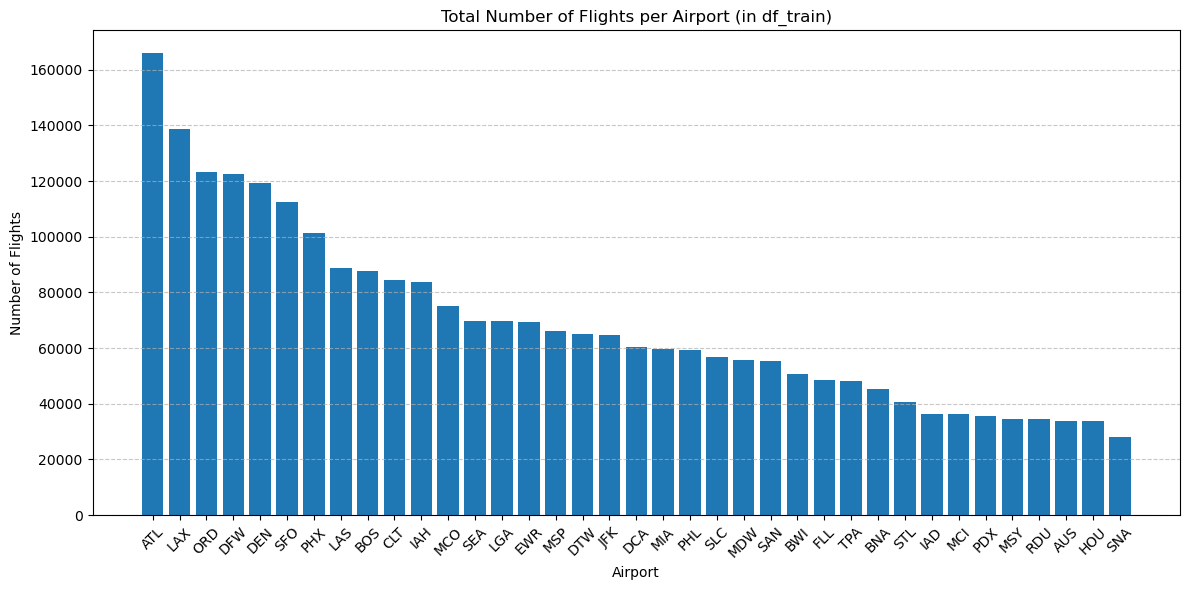

In [ ]:
import matplotlib.pyplot as plt

# Count number of flights per airport
flight_counts = df_gnn["ORIGIN"].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(flight_counts.index, flight_counts.values)
plt.title("Total Number of Flights per Airport (in df_train)")
plt.xlabel("Airport")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


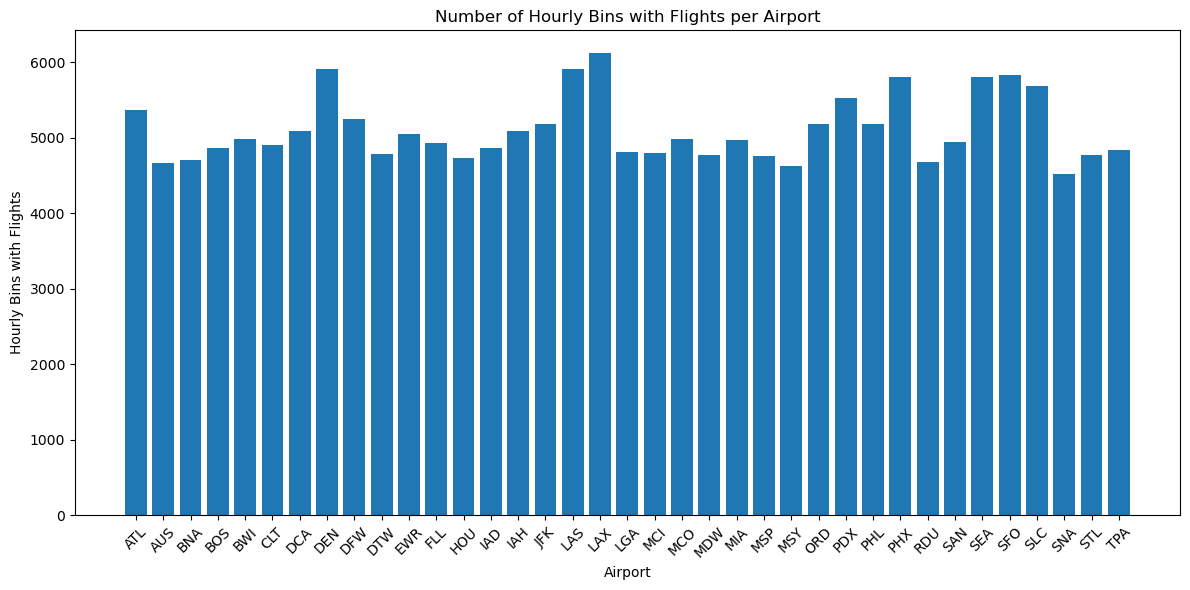

In [ ]:
# Count how many hourly bins each airport has non-NaN data in
from collections import defaultdict

flight_hours = defaultdict(int)

for ap in airports:
    df_ap = df_train[df_train["ORIGIN"] == ap]
    hourly = df_ap.groupby("time_bin").size()
    flight_hours[ap] = hourly.shape[0]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(flight_hours.keys(), flight_hours.values())
plt.title("Number of Hourly Bins with Flights per Airport")
plt.xlabel("Airport")
plt.ylabel("Hourly Bins with Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


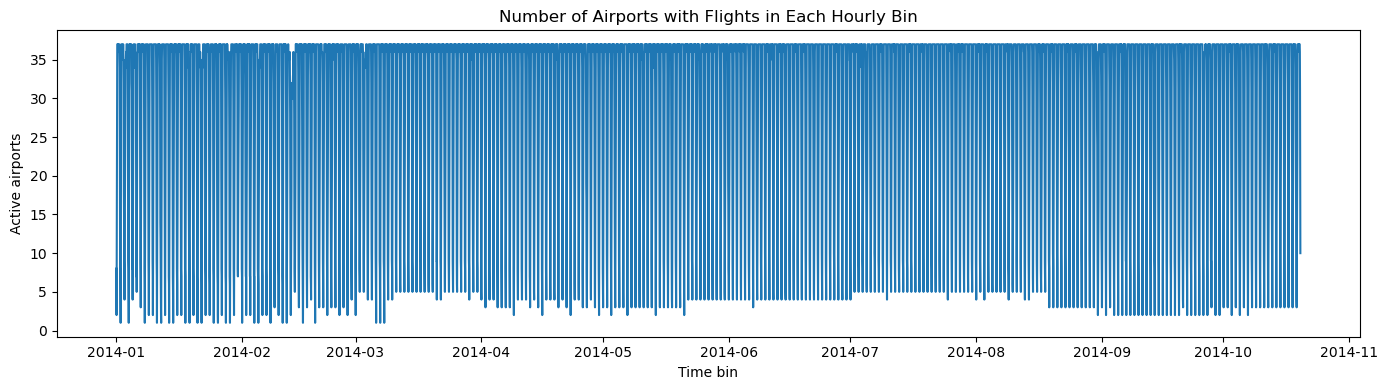

In [ ]:
# --------------------------------------------------------
# Count, for each hourly bin, the number of airports that
# recorded at least one flight in that bin
# --------------------------------------------------------
# df_train must already contain column `time_bin` (timestamp rounded to hour)
# and `ORIGIN` (airport code).
# --------------------------------------------------------

# 1) Build a cross-tab: rows = time_bin, columns = airport,
#    value = number of records.  Then convert to 0/1 (present?)
pivot = (
    df_train
    .groupby(["time_bin", "ORIGIN"]).size()   # flights per (bin, airport)
    .unstack(fill_value=0)                    # → wide table
    .astype(bool)                             # True if any flight
)

# 2) Count airports per bin
airports_per_bin = pivot.sum(axis=1)          # Series indexed by time_bin

# 3) Plot
plt.figure(figsize=(14, 4))
plt.plot(airports_per_bin.index, airports_per_bin.values)
plt.title("Number of Airports with Flights in Each Hourly Bin")
plt.xlabel("Time bin")        # x-axis is the hourly timestamp
plt.ylabel("Active airports")
plt.tight_layout()
plt.show()


In [ ]:
""" import pandas as pd, matplotlib.pyplot as plt, math, numpy as np

# ──────────────────────────────────────────────────────────────
# 0)  Build a full hourly index that covers your train period
# ──────────────────────────────────────────────────────────────
start = df_train["time_bin"].min().floor("H")
end   = df_train["time_bin"].max().ceil("H")
full_bins = pd.date_range(start, end, freq="H")          # Index length = T

# ──────────────────────────────────────────────────────────────
# 1)  For every (hour, DEST) count rows with non-NaN ARR_DELAY
#     (You can swap DEST → ORIGIN if departure-side counts needed)
# ──────────────────────────────────────────────────────────────
counts = (
    df_train
      .assign(valid = np.isfinite(df_train["ARR_DELAY"]))      # True/False
      .groupby(["time_bin", "DEST"])["valid"]
      .sum()                                                   # sum(True) → count
      .unstack(fill_value=0)                                   # wide table
      .reindex(full_bins, fill_value=0)                        # insert empty hours
      .astype(int)
)

airports = counts.columns.tolist()      # ordered list of airports
T, N     = counts.shape
print(f"    ➜ {N} airports × {T} hourly bins")

# ──────────────────────────────────────────────────────────────
# 2)  Draw one subplot per airport
# ──────────────────────────────────────────────────────────────
n_cols = math.ceil(math.sqrt(N))
n_rows = math.ceil(N / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(3.2 * n_cols, 2.4 * n_rows),
                         sharex=True, sharey=True)
axes = axes.flatten()

for ax, ap in zip(axes, airports):
    ax.plot(counts.index, counts[ap], lw=0.8)
    ax.set_title(ap, fontsize=8)
    ax.set_ylim(0, counts.values.max())          # uniform y-scale_
 """

' import pandas as pd, matplotlib.pyplot as plt, math, numpy as np\n\n# ──────────────────────────────────────────────────────────────\n# 0)  Build a full hourly index that covers your train period\n# ──────────────────────────────────────────────────────────────\nstart = df_train["time_bin"].min().floor("H")\nend   = df_train["time_bin"].max().ceil("H")\nfull_bins = pd.date_range(start, end, freq="H")          # Index length = T\n\n# ──────────────────────────────────────────────────────────────\n# 1)  For every (hour, DEST) count rows with non-NaN ARR_DELAY\n#     (You can swap DEST → ORIGIN if departure-side counts needed)\n# ──────────────────────────────────────────────────────────────\ncounts = (\n    df_train\n      .assign(valid = np.isfinite(df_train["ARR_DELAY"]))      # True/False\n      .groupby(["time_bin", "DEST"])["valid"]\n      .sum()                                                   # sum(True) → count\n      .unstack(fill_value=0)                                   # 

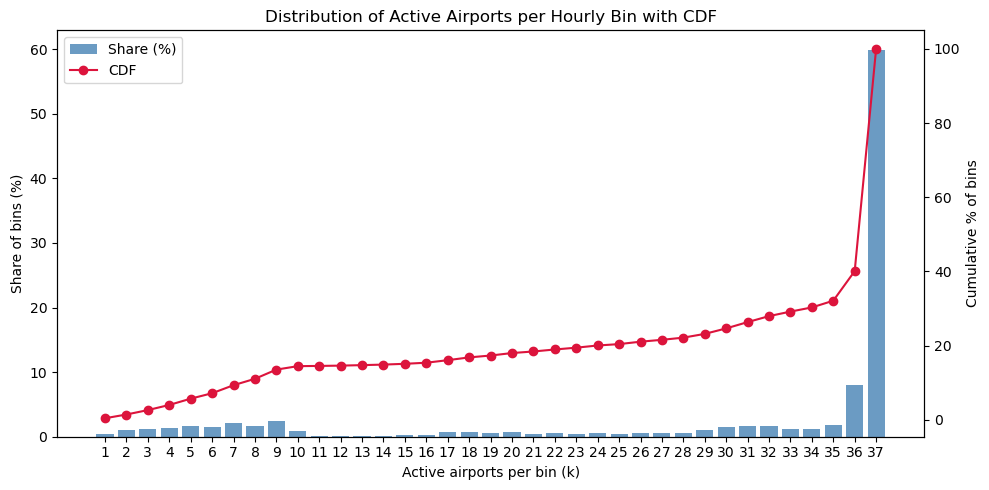

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Rebuild airports_per_bin (active airports per hour) ----------
pivot = (
    df_train
    .groupby(["time_bin", "ORIGIN"]).size()
    .unstack(fill_value=0)
    .astype(bool)
)
airports_per_bin = pivot.sum(axis=1)

# ---- Frequency & share -------------------------------------------
counts = airports_per_bin.value_counts().sort_index()
total_bins = counts.sum()
share = counts / total_bins * 100

# ---- CDF ----------------------------------------------------------
cdf = share.cumsum()

# ---- Plot ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bars: share %
bars = ax1.bar(share.index, share.values, color="steelblue", alpha=0.8, label="Share (%)")
ax1.set_xlabel("Active airports per bin (k)")
ax1.set_ylabel("Share of bins (%)")
ax1.set_xticks(range(int(share.index.min()), int(share.index.max()) + 1))
ax1.set_title("Distribution of Active Airports per Hourly Bin with CDF")

# Second y‑axis for CDF
ax2 = ax1.twinx()
ax2.plot(cdf.index, cdf.values, color="crimson", marker="o", label="CDF")
ax2.set_ylabel("Cumulative % of bins")

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.tight_layout()
plt.show()


7008


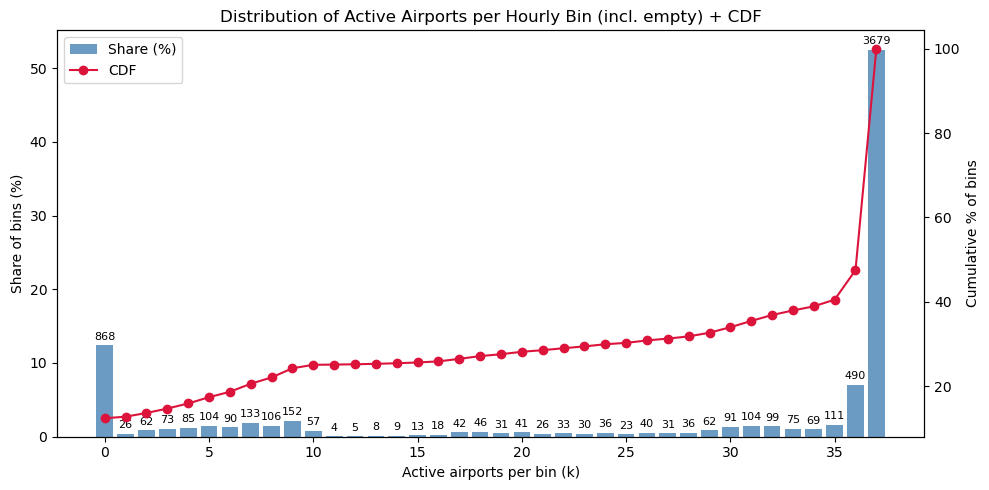

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Build a full hourly index from first to last timestamp
# ------------------------------------------------------------
start = df_train["time_bin"].min().floor("H")
end   = df_train["time_bin"].max().ceil("H")
full_bins = pd.date_range(start, end, freq="H")   # every hour

pivot = (
    df_train
      .groupby(["time_bin", "ORIGIN"]).size()
      .unstack(fill_value=0).astype(bool)
      .reindex(full_bins, fill_value=False)
)

airports_per_bin = pivot.sum(axis=1)
N_airports = pivot.shape[1]

counts = airports_per_bin.value_counts().sort_index()
print(sum(counts))
share  = counts / counts.sum() * 100                # %

cdf = share.cumsum()

fig, ax1 = plt.subplots(figsize=(10,5))

# --- bars ----------------------------------------------------
bars = ax1.bar(share.index, share.values,
               color="steelblue", alpha=0.8, label="Share (%)")

ax1.set_xlabel("Active airports per bin (k)")
ax1.set_ylabel("Share of bins (%)")

# -- put the value text on top / inside each bar --------------
for bar, pct, k in zip(bars, share.values, share.index):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2,
             height + 0.5,              # a small offset
             f"{counts[k]}",             # or use counts[k] for raw #
             ha='center', va='bottom', fontsize=8)

# --- CDF line -------------------------------------------------
ax2 = ax1.twinx()
ax2.plot(cdf.index, cdf.values,
         color="crimson", marker="o", label="CDF")
ax2.set_ylabel("Cumulative % of bins")

# combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="upper left")

plt.title("Distribution of Active Airports per Hourly Bin (incl. empty) + CDF")
plt.tight_layout()
plt.show()


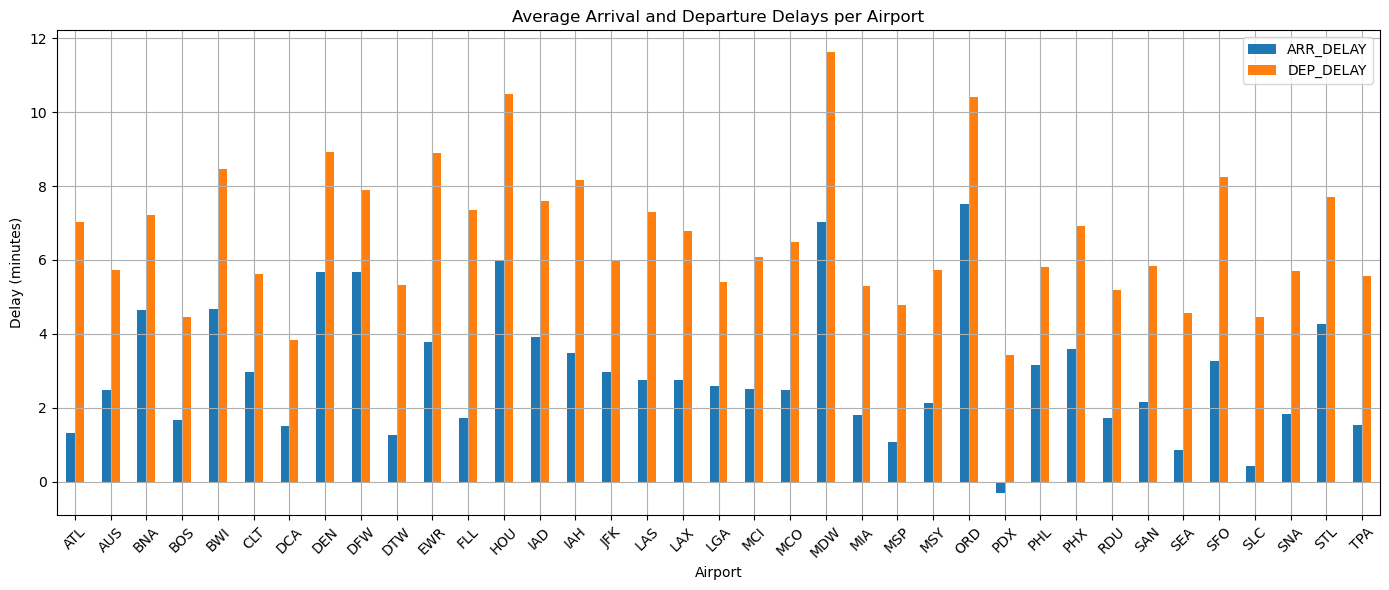

In [ ]:
import matplotlib.pyplot as plt

# Group by origin airport and compute mean delays
avg_delays = df_gnn.groupby("ORIGIN")[["ARR_DELAY", "DEP_DELAY"]].mean()

# Filter only the busiest airports
avg_delays = avg_delays.loc[airports]

avg_delays.plot(kind="bar", figsize=(14, 6))
plt.title("Average Arrival and Departure Delays per Airport")
plt.ylabel("Delay (minutes)")
plt.xlabel("Airport")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Feeding individual flights directly into a GNN creates irregular timing, misaligned graphs, duplicate data, heavy computation and noisy outliers. Aggregating flights into hourly snapshots resolves this by ensuring regular intervals, aligned airport data, balanced route representation and reduced noise.

## Scale parameters

In [ ]:
(feature_cols)

['OP_CARRIER_FL_NUM',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'FL_YEAR',
 'FL_MONTH',
 'FL_DAY',
 'dep_temp',
 'dep_dwpt',
 'dep_rhum',
 'dep_prcp',
 'dep_wdir',
 'dep_wspd',
 'dep_pres',
 'arr_temp',
 'arr_dwpt',
 'arr_rhum',
 'arr_prcp',
 'arr_wdir',
 'arr_wspd',
 'arr_pres',
 'dep_time_sin',
 'dep_time_cos',
 'arr_time_sin',
 'arr_time_cos',
 'ORIGIN_ID',
 'DEST_ID',
 'OP_CARRIER_ID']

In [ ]:

scale_cols = [
    "CRS_ELAPSED_TIME", "DISTANCE",
    "FL_MONTH", "FL_DAY", #"OP_CARRIER_ID",  "ORIGIN_ID","DEST_ID",
    # weather
    "dep_temp","dep_dwpt","dep_rhum","dep_prcp","dep_wdir","dep_wspd","dep_pres",
    "arr_temp","arr_dwpt","arr_rhum","arr_prcp","arr_wdir","arr_wspd","arr_pres"
]

# columns to pass through unchanged
passthrough_cols = [
    "dep_time_sin","dep_time_cos",
    "arr_time_sin","arr_time_cos",
   "OP_CARRIER_ID",  "ORIGIN_ID","DEST_ID"
]


hash_embed_cols = ["OP_CARRIER_FL_NUM"] 

id_cols_to_hash = ["OP_CARRIER_ID", "ORIGIN_ID", "DEST_ID"]



# Fit scaler only on valid features
scaler = StandardScaler().fit(
    df_train[scale_cols].astype(np.float32)
)


## Build X/Y tensors airport by airport

In [ ]:
# -------------------------------------------------
# helper  : build (T,F)  + (T,D) from one airport
# -------------------------------------------------
from sklearn.feature_extraction import FeatureHasher
HASH_BUCKETS = 16            # 16-dim vector per hour; tune 8…32
flight_hasher = FeatureHasher(
        n_features=HASH_BUCKETS,
        input_type="string",  # FeatureHasher needs str input
        alternate_sign=False) # keep only positive contributions

HASH_BUCKETS_ID = 8  # you can tune this
id_hashers = {
    col: FeatureHasher(n_features=HASH_BUCKETS_ID,
                       input_type="string",
                       alternate_sign=False)
    for col in id_cols_to_hash
}

def transform_block(df_block):
    # ❶ scale numeric & weather columns  ---------------------------
    X_scaled = scaler.transform(
        df_block[scale_cols].astype(np.float32)
    )

    # ❷ passthrough cyclic-time and ID columns --------------------
    X_pass = df_block[passthrough_cols].to_numpy(dtype=np.float32)

    # ❸ hash-embed the flight number ------------------------------
    flt_strs = (
        df_block["OP_CARRIER_FL_NUM"]
        .fillna("UNK")           # handle NaN, if any
        .astype(str)
        .tolist()                # python list of str
    )
    features  = [[s] for s in flt_strs]     # list-of-list
    flt_hash  = flight_hasher.transform(features) \
                                .toarray() \
                                .astype(np.float32)   # (T, 16)
     # ❹ hash-embed the ID columns -------------------------------
    id_blocks = []
    for col in id_cols_to_hash:
        col_strs = df_block[col].fillna("UNK").astype(str).tolist()
        col_feats = [[s] for s in col_strs]
        col_hash = id_hashers[col].transform(col_feats).toarray().astype(np.float32)
        id_blocks.append(col_hash)

    # ❹  concatenate order: scaled | passthrough | hashed vector
    return np.concatenate([X_scaled, X_pass, flt_hash], axis=1)
    #return np.concatenate([X_scaled, X_pass, flt_hash]+ id_blocks, axis=1) #w. hashing ID's
    #return np.concatenate([X_scaled, X_pass], axis=1) #w/o all hashing


def build_tensor(df_ap, bins):
    df_hourly = hourly_agg(df_ap, bins)

    # numeric features → float32 → scale
    X = transform_block(df_hourly).astype(np.float32)         # (T,F)

    # targets (keep 0.0 sentinel where NaN)
    Y = df_hourly[target_cols].fillna(0.0).values      # (T,D)
    return X, Y


# -------------------------------------------------
# create per-airport lists
# -------------------------------------------------
X_train_list, Y_train_list = [], []
X_test_list,  Y_test_list  = [], []

for ap in airports:                           # airports = 21 codes incl. ATL
    X_tr, Y_tr = build_tensor(df_train[df_train["ORIGIN"] == ap], train_bins)
    X_te, Y_te = build_tensor(df_test [df_test ["ORIGIN"] == ap],  test_bins)
    X_train_list.append(X_tr);  Y_train_list.append(Y_tr)
    X_test_list .append(X_te);  Y_test_list .append(Y_te)

# -------------------------------------------------
# stack & swap  → (T,N,F) etc.
# -------------------------------------------------
X_train_raw = np.swapaxes(np.stack(X_train_list), 0, 1)   # (T_train,N,F)
Y_train_raw = np.swapaxes(np.stack(Y_train_list), 0, 1)   # (T_train,N,D)
X_test_raw  = np.swapaxes(np.stack(X_test_list ), 0, 1)   # (T_test ,N,F)
Y_test_raw  = np.swapaxes(np.stack(Y_test_list ), 0, 1)   # (T_test ,N,D)

# -------------------------------------------------
# build boolean masks for valid bins
# -------------------------------------------------

# active if ≥2 airports have a non-zero target
active_train = (Y_train_raw != 0.0).any(axis=2).sum(axis=1) >= 1
active_test  = (Y_test_raw  != 0.0).any(axis=2).sum(axis=1) >= 1


# 2️⃣  ATL must be present  (at least one non-NaN feature)
#atl_idx = airports.index("ATL")
#atl_ok_train = ~np.isnan(X_train_raw[:, atl_idx, :]).all(axis=1)
#atl_ok_test  = ~np.isnan(X_test_raw [:, atl_idx, :]).all(axis=1)

valid_bins_train = active_train #& atl_ok_train
valid_bins_test  = active_test  #& atl_ok_test

train_bins_full = np.array(train_bins)          # original list-of-Timestamps
test_bins_full  = np.array(test_bins)

train_bins = np.array(train_bins)[valid_bins_train].tolist()
test_bins  = np.array(test_bins )[valid_bins_test ].tolist()

bins_kept_train = valid_bins_train.sum()
bins_kept_test  = valid_bins_test.sum()

bins_dropped_train = len(train_bins_full) - bins_kept_train
bins_dropped_test  = len(test_bins_full)  - bins_kept_test

print("===  BIN COUNTS  ===")
print(f"Train  kept / total : {bins_kept_train:5d} / {len(train_bins_full)}"
      f"   ⇒ dropped {bins_dropped_train}")
print(f"Test   kept / total : {bins_kept_test :5d} / {len(test_bins_full )}"
      f"   ⇒ dropped {bins_dropped_test}")

# -------------------------------------------------
# keep only valid bins, fill remaining NaNs with 0.0
# -------------------------------------------------
X_train = np.nan_to_num(X_train_raw[valid_bins_train], nan=0.0).astype(np.float16)
Y_train = np.nan_to_num(Y_train_raw[valid_bins_train], nan=0.0).astype(np.float16)
X_test  = np.nan_to_num(X_test_raw [valid_bins_test ], nan=0.0).astype(np.float16)
Y_test  = np.nan_to_num(Y_test_raw [valid_bins_test ], nan=0.0).astype(np.float16)

nan_X_train = np.isnan(X_train_raw[valid_bins_train]).sum()
nan_Y_train = np.isnan(Y_train_raw[valid_bins_train]).sum()
nan_X_test  = np.isnan(X_test_raw [valid_bins_test ]).sum()
nan_Y_test  = np.isnan(Y_test_raw [valid_bins_test ]).sum()

print("\n===  ZERO-FILLS  (NaN ➜ 0.0)  ===")
print(f"Train  features (X) : {nan_X_train:,}")
print(f"Train  targets  (Y) : {nan_Y_train:,}")
print(f"Test   features (X) : {nan_X_test :,}")
print(f"Test   targets  (Y) : {nan_Y_test :,}")
print("Shapes  X_train:", X_train.shape, "| X_test:", X_test.shape)
print("Shapes  Y_train:", Y_train.shape, "| Y_test:", Y_test.shape)




===  BIN COUNTS  ===
Train  kept / total :  6140 / 7008   ⇒ dropped 868
Test   kept / total :  1573 / 1752   ⇒ dropped 179

===  ZERO-FILLS  (NaN ➜ 0.0)  ===
Train  features (X) : 1,061,842
Train  targets  (Y) : 0
Test   features (X) : 300,849
Test   targets  (Y) : 0
Shapes  X_train: (6140, 37, 41) | X_test: (1573, 37, 41)
Shapes  Y_train: (6140, 37, 2) | Y_test: (1573, 37, 2)


In [ ]:
sample = df_train["OP_CARRIER_FL_NUM"].head(3).astype(str).values
print("Original:", sample)
print("Hashed  :", flight_hasher.transform([[s] for s in sample]).toarray())


Original: ['1830' '1052' '1899']
Hashed  : [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [ ]:
assert len(train_bins) == X_train.shape[0]
assert len(test_bins)  == X_test.shape[0]

6140


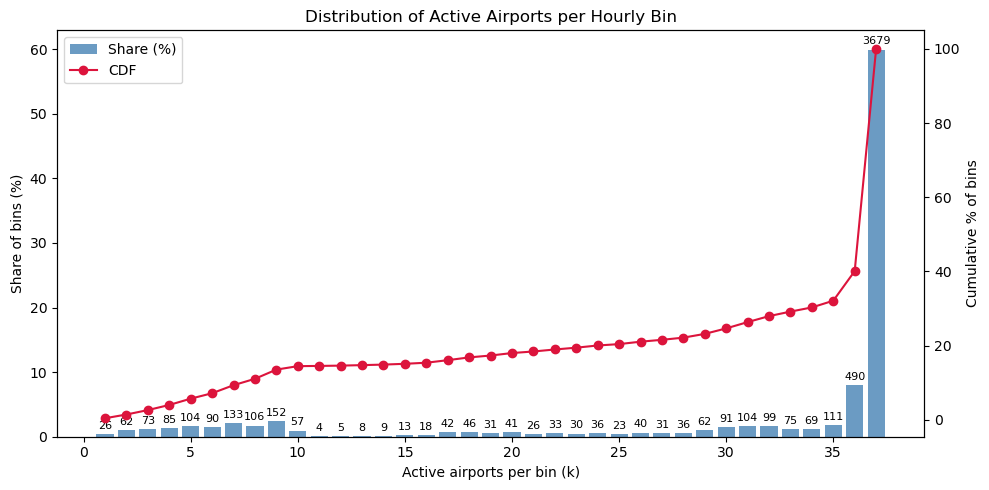

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Build a full hourly index from first to last timestamp
# ------------------------------------------------------------
start = df_train["time_bin"].min().floor("H")
end   = df_train["time_bin"].max().ceil("H")
full_bins = pd.date_range(start, end, freq="H")   # every hour

pivot = (
    df_train
      .groupby(["time_bin", "ORIGIN"])
      .size()
      .unstack(fill_value=0)          # (no .reindex)
      .astype(bool)
)


airports_per_bin = pivot.sum(axis=1)
N_airports = pivot.shape[1]

counts = airports_per_bin.value_counts().sort_index()
print(sum(counts))
share  = counts / counts.sum() * 100                # %

cdf = share.cumsum()

fig, ax1 = plt.subplots(figsize=(10,5))

# --- bars ----------------------------------------------------
bars = ax1.bar(share.index, share.values,
               color="steelblue", alpha=0.8, label="Share (%)")

ax1.set_xlabel("Active airports per bin (k)")
ax1.set_ylabel("Share of bins (%)")

# -- put the value text on top / inside each bar --------------
for bar, pct, k in zip(bars, share.values, share.index):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2,
             height + 0.5,              # a small offset
             f"{counts[k]}",             # or use counts[k] for raw #
             ha='center', va='bottom', fontsize=8)

# --- CDF line -------------------------------------------------
ax2 = ax1.twinx()
ax2.plot(cdf.index, cdf.values,
         color="crimson", marker="o", label="CDF")
ax2.set_ylabel("Cumulative % of bins")

# combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="upper left")

plt.title("Distribution of Active Airports per Hourly Bin")
plt.tight_layout()
plt.show()


In [ ]:
""" import numpy as np
import matplotlib.pyplot as plt

def active_airports_per_bin(X, bins, name):
  
    # 1️⃣  A bin is 'active' for airport j if *any* feature/target ≠ 0.0
    #     axis=2 collapses features ➜ (T, N) boolean mask
    active_mask = (X != 0.0).any(axis=2)

    # 2️⃣  Count active airports for every time step
    counts = active_mask.sum(axis=1)          # shape (T,)

    # 3️⃣  Plot
    plt.figure(figsize=(14, 3))
    plt.plot(bins, counts)
    plt.title(f"Active airports per hourly bin – {name}")
    plt.ylabel("# active airports")
    plt.xlabel("Time bin")
    plt.ylim(0, X.shape[1]+1)
    plt.tight_layout()
    plt.show()

# ── call for each split ─────────────────────────────
active_airports_per_bin(X_train, train_bins, "Train  X")
active_airports_per_bin(X_test ,  test_bins,  "Test   X")
active_airports_per_bin(Y_train, train_bins, "Train  Y")
active_airports_per_bin(Y_test ,  test_bins,  "Test   Y")
 """

' import numpy as np\nimport matplotlib.pyplot as plt\n\ndef active_airports_per_bin(X, bins, name):\n  \n    # 1️⃣  A bin is \'active\' for airport j if *any* feature/target ≠ 0.0\n    #     axis=2 collapses features ➜ (T, N) boolean mask\n    active_mask = (X != 0.0).any(axis=2)\n\n    # 2️⃣  Count active airports for every time step\n    counts = active_mask.sum(axis=1)          # shape (T,)\n\n    # 3️⃣  Plot\n    plt.figure(figsize=(14, 3))\n    plt.plot(bins, counts)\n    plt.title(f"Active airports per hourly bin – {name}")\n    plt.ylabel("# active airports")\n    plt.xlabel("Time bin")\n    plt.ylim(0, X.shape[1]+1)\n    plt.tight_layout()\n    plt.show()\n\n# ── call for each split ─────────────────────────────\nactive_airports_per_bin(X_train, train_bins, "Train  X")\nactive_airports_per_bin(X_test ,  test_bins,  "Test   X")\nactive_airports_per_bin(Y_train, train_bins, "Train  Y")\nactive_airports_per_bin(Y_test ,  test_bins,  "Test   Y")\n '

In [ ]:
""" import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1.  Boolean mask : True if that airport has ANY non-zero target in the bin
#    Y_train shape = (T, N, target_dim)
# ------------------------------------------------------------------
mask = (Y_train != 0).any(axis=2)          # (T, N)

# 2.  Count active airports per time bin
airports_per_bin = mask.sum(axis=1)        # length T, dtype=int
N_airports       = Y_train.shape[1]

# 3.  Frequency table → share (%) and CDF
counts   = pd.Series(airports_per_bin).value_counts().sort_index()
share    = counts / counts.sum() * 100          # %
cdf      = share.cumsum()

# 4.  Plot histogram + CDF
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(share.index, share.values,
        color="steelblue", alpha=0.8, label="Share (%)")
ax1.set_xlabel("Active airports per bin (k)")
ax1.set_ylabel("Share of bins (%)")
ax1.set_xticks(range(int(share.index.min()), int(share.index.max()) + 1))

ax2 = ax1.twinx()
ax2.plot(cdf.index, cdf.values,
         color="crimson", marker="o", label="CDF")
ax2.set_ylabel("Cumulative % of bins")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Active-Airport Distribution per Hourly Bin (after build_tensor)")
plt.tight_layout()
plt.show()

# 5.  Print quick stats
print(f"Total bins analysed  : {counts.sum()}")
print(f"Mean airports/bin    : {airports_per_bin.mean():.2f} / {N_airports}")
print(f"Std-dev airports/bin : {airports_per_bin.std():.2f}")
 """

' import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# ------------------------------------------------------------------\n# 1.  Boolean mask : True if that airport has ANY non-zero target in the bin\n#    Y_train shape = (T, N, target_dim)\n# ------------------------------------------------------------------\nmask = (Y_train != 0).any(axis=2)          # (T, N)\n\n# 2.  Count active airports per time bin\nairports_per_bin = mask.sum(axis=1)        # length T, dtype=int\nN_airports       = Y_train.shape[1]\n\n# 3.  Frequency table → share (%) and CDF\ncounts   = pd.Series(airports_per_bin).value_counts().sort_index()\nshare    = counts / counts.sum() * 100          # %\ncdf      = share.cumsum()\n\n# 4.  Plot histogram + CDF\nfig, ax1 = plt.subplots(figsize=(10, 5))\n\nax1.bar(share.index, share.values,\n        color="steelblue", alpha=0.8, label="Share (%)")\nax1.set_xlabel("Active airports per bin (k)")\nax1.set_ylabel("Share of bins (%)")\nax1.set_xticks(ran

In [ ]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test  shape:", X_test.shape)
print("Y_test  shape:", Y_test.shape)

print("Unique target_cols:", target_cols)
print("Scaler input features:", scaler.feature_names_in_)


X_train shape: (6140, 37, 41)
Y_train shape: (6140, 37, 2)
X_test  shape: (1573, 37, 41)
Y_test  shape: (1573, 37, 2)
Unique target_cols: ['ARR_DELAY', 'DEP_DELAY']
Scaler input features: ['CRS_ELAPSED_TIME' 'DISTANCE' 'FL_MONTH' 'FL_DAY' 'dep_temp' 'dep_dwpt'
 'dep_rhum' 'dep_prcp' 'dep_wdir' 'dep_wspd' 'dep_pres' 'arr_temp'
 'arr_dwpt' 'arr_rhum' 'arr_prcp' 'arr_wdir' 'arr_wspd' 'arr_pres']


In [ ]:
df_gnn["ARR_DELAY"].describe()

count    2.560324e+06
mean     3.117394e+00
std      2.260826e+01
min     -2.800000e+01
25%     -1.100000e+01
50%     -3.000000e+00
75%      1.000000e+01
max      1.100000e+02
Name: ARR_DELAY, dtype: float64

## spatiotemporal adjacency matrix

It produces a 3D tensor A[t, i, j] where:
- t = time window
- i, j = origin and destination airport index
- value = normalized number of flights from airport i to j at time t

## Blend static + dynamic graphs

In [ ]:
# ------------------------------------------------------------
# Keep only airports that occur in ORIGIN or DEST
# across *both* train and test frames
# ------------------------------------------------------------
active_airports = sorted(
      set(df_train["ORIGIN"]).union(df_train["DEST"])
    | set(df_test ["ORIGIN"]).union(df_test ["DEST"])
)

dropped = set(airports) - set(active_airports)
if dropped:
    print(f"Dropping {len(dropped)} inactive airports: {sorted(dropped)}")

airports = active_airports
N        = len(airports)
airport_to_idx = {iata: i for i, iata in enumerate(airports)}

# A_spatial was created with the *old* airports order
# Build a boolean mask of the kept airports


In [ ]:
len(airports)

37

In [ ]:
# ---------------------------------------------------------------------------
# Throughput-adjacency perfectly aligned
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# Throughput adjacency [T, N, N]  –– every hour, ORIGIN → DEST counts
# ---------------------------------------------------------------------------



def throughput_adjacency(df_sub, bins, airports):
    df_sub = df_sub.copy()
    df_sub["time_bin"] = df_sub["time_bin"].dt.floor("H")

    # rows:  (time_bin, ORIGIN)     columns: DEST
    grouped = (
        df_sub.groupby(["time_bin", "ORIGIN"])["DEST"]
              .value_counts()
              .unstack(fill_value=0)
    )

    full_index = pd.MultiIndex.from_product([bins, airports])

    # 1️⃣  make sure *every* (hour, ORIGIN) row exists
    grouped = grouped.reindex(full_index, fill_value=0)

    # 2️⃣  and be sure we have exactly the airport set as columns
    grouped = grouped.reindex(columns=airports, fill_value=0)

    # 3️⃣  reshape → [T, N, N]
    T, N = len(bins), len(airports)
    mat3d = grouped.to_numpy().reshape(T, N, N).astype(np.float32)

    # Optional: row-normalise so each origin’s outgoing probs sum to 1
    row_sums = mat3d.sum(axis=2, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    return mat3d / row_sums



#A_static = np.asarray(A_spatial, dtype=np.float32)    # (N, N)
# A fresh distance-based adjacency that matches the final airport list
#airport_coords = node_df[["latitude_deg", "longitude_deg"]].to_numpy()


A_train = throughput_adjacency(df_train, train_bins, airports)
A_test  = throughput_adjacency(df_test,  test_bins,  airports)

A_static = np.asarray(A_spatial, dtype=np.float32) 
row_sums = A_static.sum(1, keepdims=True) + 1e-6
A_static = (A_static / row_sums).astype(np.float32)


# expand static slice to 3-D so shapes match dynamic
A_static3d_train = np.broadcast_to(A_static, A_train.shape)
A_static3d_test  = np.broadcast_to(A_static,  A_test.shape)

# ------------------------------------------------------------
# 3.  Blend static + dynamic   (α≈0.5 works well)
# ------------------------------------------------------------

deg_dyn = (A_train > 0).sum(-1)        # [T, N] out-degrees
print("Median out-degree (all bins):", np.median(deg_dyn))
print("Min out-degree (all bins)   :", deg_dyn.min())
density = (A_train > 0).mean()
print("Edge density per bin:", density.round(3))

alpha   = 0.4
A_train = alpha * A_static3d_train + (1 - alpha) * A_train
A_test  = alpha * A_static3d_test  + (1 - alpha) * A_test





Median out-degree (all bins): 7.0
Min out-degree (all bins)   : 0
Edge density per bin: 0.209


| α value | Effect                                  | When that makes sense                                                                                                                                                                             |
| ------- | --------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0.0** | Use **only** the raw dynamic adjacency. | If you have *dense, low-noise, never-missing* traffic data in every time bin.                                                                                                                     |
| **0.5** | Equal blend (what the snippet does).    | A practical default: dynamic variation is preserved, but every edge has at least half of its long-run strength, preventing the graph from “disappearing” when no flights occurred in a short bin. |
| **1.0** | Use **only** the static backbone.       | Useful for ablation or when you want a purely spatial GNN.                                                                                                                                        |


In [ ]:
deg_dyn = (A_train > 0).sum(-1)        # [T, N] out-degrees
print("Median out-degree (all bins):", np.median(deg_dyn))
print("Min out-degree (all bins)   :", deg_dyn.min())
density = (A_train > 0).mean()
print("Edge density per bin:", density.round(3))

Median out-degree (all bins): 14.0
Min out-degree (all bins)   : 1
Edge density per bin: 0.365


In [ ]:
import numpy as np, networkx as nx
alphas = [0.15, 0.25, 0.35, 0.45]
keep_pct = 10         # keep top 10 % strongest edges, purely for connectivity test
gc_ratio = {}

for a in alphas:
    # blend *one representative day* for speed
    A = a*A_static3d_train[0] + (1-a)*A_train[0]        # shape [N, N]
    thresh = np.percentile(A, 100 - keep_pct)
    G = nx.from_numpy_array((A >= thresh).astype(int), create_using=nx.DiGraph)
    giant = max(nx.weakly_connected_components(G), key=len)
    gc_ratio[a] = len(giant) / G.number_of_nodes()

print(gc_ratio)

{0.15: 0.972972972972973, 0.25: 0.972972972972973, 0.35: 0.972972972972973, 0.45: 0.972972972972973}


In [ ]:
A_train.shape

(6140, 37, 37)

| Problem (old code)                                                  | Fix in the snippet                                                                      |
| ------------------------------------------------------------------- | --------------------------------------------------------------------------------------- |
| **Max-route scaling** made edges incomparable between origins       | Replaced by strict *row* normalisation → every origin’s outgoing probabilities sum to 1 |
| Group-by used `DEST` first, so reshaping sometimes mis-ordered axes | Group-by now uses `ORIGIN` first ⇒ direct reshape to `[T,N,N]` is safe                  |
| `A_static` was mixed as a **2-D** array with a 3-D dynamic tensor   | We broadcast `A_static` to `[T,N,N]` before blending                                    |
| Float16 caused underflow in tiny edges                              | Everything is kept in **float32** (Spektral prefers that)                               |


In [ ]:
import folium
from tqdm import tqdm

# Use the index (iata_code) directly
airport_coords = node_df[["latitude_deg", "longitude_deg"]].to_dict("index")

# Create base map
m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles='CartoDB positron')

# Draw edges from static adjacency matrix
N = len(airports)
for i in range(N):
    for j in range(N):
        weight = A_static[i, j]
        if weight > 0.01:  # Skip weak links
            origin_code = airports[i]
            dest_code   = airports[j]

            # Skip missing coordinates (just in case)
            if origin_code not in airport_coords or dest_code not in airport_coords:
                continue

            origin = airport_coords[origin_code]
            dest   = airport_coords[dest_code]

            folium.PolyLine(
                locations=[
                    (origin["latitude_deg"], origin["longitude_deg"]),
                    (dest["latitude_deg"], dest["longitude_deg"])
                ],
                color='blue',
                weight=2,
                opacity=min(0.3 + weight * 5, 1.0)
            ).add_to(m)

# Show the map
m


In [ ]:
import folium
from tqdm import tqdm

# Map IATA → (lat, lon)
airport_coords = {
    iata: (row["latitude_deg"], row["longitude_deg"])
    for iata, row in node_df.iterrows()
}

# Create base map
m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles='CartoDB positron')

# Add edges for the first time slice of A_train
N = len(airports)
A_slice = A_train[0]  # You could average over time: A_train.mean(axis=0)

for i in range(N):
    for j in range(N):
        weight = A_slice[i, j]
        if weight > 0.01:  # skip very low-weight edges for clarity
            origin = airports[i]
            dest = airports[j]

            lat1, lon1 = airport_coords[origin]
            lat2, lon2 = airport_coords[dest]

            folium.PolyLine(
                [(lat1, lon1), (lat2, lon2)],
                color="blue",
                weight=2,
                opacity=0.5,
            ).add_to(m)

# Optional: add airport markers
for iata, (lat, lon) in airport_coords.items():
    folium.CircleMarker(location=[lat, lon], radius=3, color='red', fill=True, fill_opacity=0.7).add_to(m)

# Save or display map
m.save("blended_adjacency_map.html")
m


## Blend static + dynamic graphs

In [ ]:
print("All tensors aligned:")
print("   X_train:", X_train.shape, "| A_train:", A_train.shape, "| Y_train:", Y_train.shape)
print("   X_test :", X_test.shape , "| A_test :", A_test.shape , "| Y_test :", Y_test.shape)

All tensors aligned:
   X_train: (6140, 37, 41) | A_train: (6140, 37, 37) | Y_train: (6140, 37, 2)
   X_test : (1573, 37, 41) | A_test : (1573, 37, 37) | Y_test : (1573, 37, 2)


# Create Spatio-Temporal windows
This function systematically transforms raw spatio-temporal arrays (features, adjacency matrices, and target labels) into structured sequences suitable for the GNN. It generates training batches by aligning past input sequences (lookback) with future prediction targets (lookahead), ensuring efficient model training.

In [ ]:
def createDataset(
    Features: np.ndarray,       # shape: [T, N, F]
    Adjacencies: np.ndarray,    # shape: [T, N, N]
    Targets: np.ndarray,        # shape: [T, N, D]
    lookback: int,
    lookahead: int,
    batch_size: int = 32
):
    """
    Creates a tf.data.Dataset of batched spatiotemporal windows.

    Args:
        Features (np.ndarray):    shape (T, N, F)
        Adjacencies (np.ndarray): shape (T, N, N)
        Targets (np.ndarray):     shape (T, N, D)
        lookback (int):           input sequence length
        lookahead (int):          target sequence length
        batch_size (int):         training batch size

    Returns:
        tf.data.Dataset: batched dataset yielding ((X_window, A_window), Y_target)
    """

    F_samples, A_samples, Y_samples = [], [], []

    T = Features.shape[0]
    for idx in range(T - lookback - lookahead + 1):
        F_samples.append(Features[idx:idx+lookback])                    # [lookback, N, F]
        A_samples.append(Adjacencies[idx:idx+lookback])                # [lookback, N, N]
        Y_samples.append(Targets[idx+lookback:idx+lookback+lookahead])  # [lookahead, N, D]

    # Convert to arrays
    features = np.array(F_samples, dtype=np.float32)
    adjacencies = np.array(A_samples, dtype=np.float32)
    labels = np.array(Y_samples, dtype=np.float32)

    # Remove remainder to form full batches
    batchCutoff = features.shape[0] - (features.shape[0] % batch_size)
    features = features[:batchCutoff]
    adjacencies = adjacencies[:batchCutoff]
    labels = labels[:batchCutoff]

    # Construct tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices(((features, adjacencies), labels))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    print(f"Feature batch shape: {features.shape}")      # [num_samples, lookback, N, F]
    print(f"Adjacency batch shape: {adjacencies.shape}") # [num_samples, lookback, N, N]
    print(f"Target batch shape: {labels.shape}")         # [num_samples, lookahead, N, D]


    return dataset


# Hyper params

In [ ]:
batch_size = 32
lookback = 16
lookahead = 2
l2_reg = 2.5e-5
dropout = 0.3
channels = 10
attn_heads = 10
lstm_units = 60
num_labels = len(target_cols) # ARR_DELAY, DEP_DELAY
N = X_train.shape[1]   # # airports / nodes
F = X_train.shape[2]   # # node features
patience = 15
epochs = 100
widths = (64,32,16)

In [ ]:

X_tr, X_val, A_tr, A_val, Y_tr, Y_val = train_test_split(
    X_train, A_train, Y_train, test_size=0.20, shuffle=False  # no shuffle: time series
)

print("Train:")
train_dataset = createDataset(X_tr, A_tr, Y_tr, lookback, lookahead, batch_size)
print("\nVal:")
val_dataset   = createDataset(X_val, A_val, Y_val, lookback, lookahead, batch_size)
print("\nTest:")
test_dataset = createDataset(X_test, A_test, Y_test, lookback, lookahead, batch_size=batch_size)

Train:
Feature batch shape: (4864, 16, 37, 41)
Adjacency batch shape: (4864, 16, 37, 37)
Target batch shape: (4864, 2, 37, 2)

Val:
Feature batch shape: (1184, 16, 37, 41)
Adjacency batch shape: (1184, 16, 37, 37)
Target batch shape: (1184, 2, 37, 2)

Test:
Feature batch shape: (1536, 16, 37, 41)
Adjacency batch shape: (1536, 16, 37, 37)
Target batch shape: (1536, 2, 37, 2)


making sure our model is alright

In [ ]:
print("Pct. zeros in Y_train:", (Y_train == 0).mean().round(3))
print("Min active airports :", (X_train!=0).any(-1).sum(1).min())





Pct. zeros in Y_train: 0.172
Min active airports : 37


# Model STGNN

In [ ]:


# ───────────────────────── ST-Conv block ─────────────────────────
class STConvBlock(layers.Layer):
    """
    Spatio-Temporal Convolutional Block.
    Applies:
    - Spatial graph step (dense over adjacency)
    - Temporal step (1D conv across time)
    - BatchNorm + Dropout
    """
    def __init__(self, filters: int, num_nodes: int, kernel: int = 3,
                 dropout_rate: float = 0.3, l2_reg: float = 0.0, **kw):
        super().__init__(**kw)
        self.filters = filters

        self.num_nodes = num_nodes

        # Regularization
        reg = regularizers.l2(l2_reg) if l2_reg > 0 else None

        # Layers
        self.spatial  = layers.Dense(filters, use_bias=False, kernel_regularizer=reg)
        self.temporal = layers.Conv1D(filters, kernel, padding="same", activation="relu")
        self.bn       = layers.BatchNormalization()
        self.dropout  = layers.Dropout(dropout_rate)

    def call(self, x, adj, training=False):
        # x:   [B, T, N, F]
        # adj: [B, T, N, N]
        B = tf.shape(x)[0]

       
        T = tf.shape(x)[1]
    
        N = self.num_nodes

        # Spatial step
        x_flat   = tf.reshape(x,   [-1, N, tf.shape(x)[-1]])      # [B*T, N, F]
        adj_flat = tf.reshape(adj, [-1, N, N])                    # [B*T, N, N]
        x_spat   = self.spatial(tf.matmul(adj_flat, x_flat))     # [B*T, N, C]
        x_spat   = tf.reshape(x_spat, [B, T, N, self.filters])    # [B, T, N, C]

        # Temporal step
        x_tmp = tf.transpose(x_spat, [0, 2, 1, 3])                # [B, N, T, C]
        x_tmp = tf.reshape(x_tmp, [B * N, T, self.filters])       # [B*N, T, C]
        x_tmp = self.temporal(x_tmp)                              # [B*N, T, C]
        x_tmp = self.bn(x_tmp, training=training)
        x_tmp = self.dropout(x_tmp, training=training)

        x_tmp = tf.reshape(x_tmp, [B, N, T, self.filters])
        return tf.transpose(x_tmp, [0, 2, 1, 3])                  # [B, T, N, C]


# ───────────────────────── full STGCN ───────────────────────────
class STGCN(Model):
    """
    Full Spatio-Temporal Graph Convolutional Network.
    Input shape:  x   → [B, lookback, N, F]
                  adj → [B, lookback, N, N]
    Output shape: ŷ  → [B, lookahead, N, num_labels]
    """
    def __init__(self, num_nodes: int, num_features: int, num_labels: int,
                 lookback: int, lookahead: int,
                 dropout: float, l2_reg: float, widths=widths, **kw):
        super().__init__(**kw)

        self.num_nodes   = num_nodes
        self.num_labels  = num_labels
        self.lookahead   = lookahead

        # --- build a list of STConvBlocks on the fly -------------
        self.blocks = [
            STConvBlock(ch, num_nodes=num_nodes,
                        dropout_rate=dropout, l2_reg=l2_reg,
                        name=f"st_block_{i+1}")
            for i, ch in enumerate(widths)
        ]

     

        self.proj = layers.Dense(num_labels)

    def call(self, inputs, training=False):
        x, adj = inputs  # x: [B, T, N, F], adj: [B, T, N, N]

        for block in self.blocks:
            x = block(x, adj, training)
     
  
        x = x[:, -self.lookahead:, :, :]  # [B, lookahead, N, C]
        x = self.proj(x)                  # [B, lookahead, N, D]

        return x


In [ ]:
def loss_fn(y_true, y_pred, sample_weight=None):
    if sample_weight is None:
        # fallback to normal MAE if no mask given
        return tf.reduce_mean(tf.abs(y_true - y_pred))
    else:
        return masked_mae(y_true, y_pred, sample_weight)


model = STGCN(
    num_nodes=N,
    num_features=F,
    num_labels=num_labels,
    lookback=lookback,
    lookahead=lookahead,
    dropout=dropout,
    l2_reg=l2_reg,  
    widths=widths
)




def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)        # 0 = no flight
    ae   = tf.abs(y_true - y_pred) * mask
    return tf.reduce_sum(ae) / tf.reduce_sum(mask)

def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    se   = tf.square(y_true - y_pred) * mask
    return tf.reduce_sum(se) / tf.reduce_sum(mask)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
              loss=masked_mse,
              metrics=[masked_mae])


# …re-train or load weights …
test_mse, test_mae = model.evaluate(test_dataset, verbose=0)
print(f"Test MSE : {test_mse:.4f}")
print(f"Test MAE : {test_mae:.4f}")


Test MSE : 159.3207
Test MAE : 8.5852


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early = EarlyStopping(
    monitor="val_loss",           # what to watch
    patience=15,                   # wait this many epochs for improvement
    restore_best_weights=True     # load best weights back if stopped early
)
lr_sched = tf.keras.callbacks.ReduceLROnPlateau(
              monitor='val_loss', factor=0.5, patience=8)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,    # just one epoch for debugging
    callbacks=[ early, lr_sched]
)


Epoch 1/100
152/152 [==============================] - 8s 47ms/step - loss: 168.3819 - masked_mae: 8.6920 - val_loss: 123.9580 - val_masked_mae: 7.4582 - lr: 0.0010
Epoch 2/100
152/152 [==============================] - 10s 69ms/step - loss: 157.2691 - masked_mae: 8.5905 - val_loss: 118.2153 - val_masked_mae: 7.5118 - lr: 0.0010
Epoch 3/100
152/152 [==============================] - 9s 57ms/step - loss: 155.5965 - masked_mae: 8.6074 - val_loss: 117.7517 - val_masked_mae: 7.5410 - lr: 0.0010
Epoch 4/100
152/152 [==============================] - 7s 47ms/step - loss: 154.9383 - masked_mae: 8.6062 - val_loss: 122.8324 - val_masked_mae: 8.0186 - lr: 0.0010
Epoch 5/100
152/152 [==============================] - 8s 50ms/step - loss: 154.1749 - masked_mae: 8.6082 - val_loss: 118.9724 - val_masked_mae: 7.6969 - lr: 0.0010
Epoch 6/100
152/152 [==============================] - 8s 56ms/step - loss: 153.6718 - masked_mae: 8.5812 - val_loss: 118.5452 - val_masked_mae: 7.7317 - lr: 0.0010
Epoch 7/1

In [ ]:
model.summary()

Model: "stgcn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 st_block_1 (STConvBlock)    multiple                  15232     
                                                                 
 st_block_2 (STConvBlock)    multiple                  5280      
                                                                 
 st_block_3 (STConvBlock)    multiple                  1360      
                                                                 
 dense_11 (Dense)            multiple                  34        
                                                                 
Total params: 21906 (85.57 KB)
Trainable params: 21682 (84.70 KB)
Non-trainable params: 224 (896.00 Byte)
_________________________________________________________________


In [ ]:


# Inspect what TensorFlow can “see”
print("Visible devices:", tf.config.list_physical_devices())

# Optional: show only GPUs
print("GPUs:", tf.config.list_physical_devices('GPU'))

# ---- now carry on with the usual code ----
# … build adjacency tensors, define the ST-GNN, compile, fit, etc.


Visible devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs: []


In [ ]:
test_mse, test_mae = model.evaluate(test_dataset)
print(f"Test MSE : {test_mse: .4f}")
print(f"Test MAE : {test_mae: .4f}")

 1/48 [..............................] - ETA: 3s - loss: 80.7481 - masked_mae: 6.6805

48/48 [==============================] - 1s 23ms/step - loss: 121.5031 - masked_mae: 7.7855
Test MSE :  121.5031
Test MAE :  7.7855


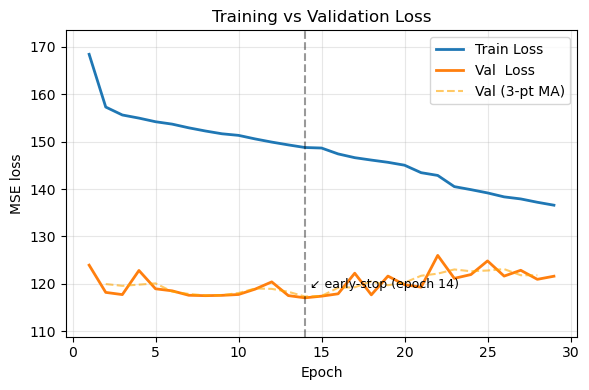

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- basic curves -------------------------------------------------
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, label='Train Loss', lw=2)
plt.plot(epochs, val_loss,   label='Val  Loss', lw=2)
import pandas as pd
val_smoothed = pd.Series(val_loss).rolling(3, center=True).mean()
plt.plot(epochs, val_smoothed, ls='--', color='orange',
         alpha=.6, label='Val (3-pt MA)')


# --- early–stopping marker ---------------------------------------
best_epoch = np.argmin(val_loss) + 1        # +1 because epochs are 1-based
plt.axvline(best_epoch, ls='--', color='k', alpha=.4)
plt.text(best_epoch+0.3, min(val_loss)+2,
         f"↙ early-stop (epoch {best_epoch})", fontsize=9, color='k')

# --- cosmetics ----------------------------------------------------
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training vs Validation Loss")
#plt.ylim(min(val_loss)*0.95, max(train_loss)*1.05)   # tight y-range
plt.ylim(min(val_loss)*0.93, max(train_loss)*1.03)

#plt.xticks(epochs)                                   # integer ticks
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_per_horizon(y_true, y_pred, labels):
    """
    Evaluates masked MAE, MSE, and R2 for each time step in the lookahead window.

    y_true, y_pred: arrays of shape [B, 2, N, D]
    labels: list of target names, e.g., ["ARR_DELAY", "DEP_DELAY"]
    """
    assert y_true.shape == y_pred.shape
    B, H, N, D = y_true.shape

    for h in range(H):
        print(f"\n===== HORIZON {h+1} (t+{h+1}) =====")
        yt_h = y_true[:, h, :, :].reshape(-1, D)
        yp_h = y_pred[:, h, :, :].reshape(-1, D)

        for i in range(D):
            mask = yt_h[:, i] != 0.0
            mae = mean_absolute_error(yt_h[mask, i], yp_h[mask, i])
            mse = np.mean((yt_h[mask, i] - yp_h[mask, i])**2)
            r2  = r2_score(yt_h[mask, i], yp_h[mask, i])

            print(f"{labels[i]:<10} | MAE: {mae:6.2f} | MSE: {mse:6.2f} | R²: {r2:6.3f}")


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict
y_pred = model.predict(test_dataset, verbose=0)

# Extract ground-truth values from test_dataset
y_true_batches = [y.numpy() for (_, _), y in test_dataset if y.shape[0] == batch_size]
y_true = np.concatenate(y_true_batches, axis=0)

# Flatten: [B, H, N, D] → [B * H * N, D]
yt = y_true.reshape(-1, y_true.shape[-1])
yp = y_pred.reshape(-1, y_pred.shape[-1])

# Get number of targets and labels
n_targets = yt.shape[1]
labels = ["Arrival", "Departure"] if n_targets == 2 else ["Target"]

# Mask out padded (non-real) values: only evaluate where y_true ≠ 0.0a
print("\n=====  MASKED TEST-SET METRICS  =====")
for i in range(n_targets):
    mask = yt[:, i] != 0.0
    mae = mean_absolute_error(yt[mask, i], yp[mask, i])
    mse = mean_squared_error(yt[mask, i], yp[mask, i])
    r2  = r2_score(yt[mask, i], yp[mask, i])
    print(f"{labels[i]:<9}  MAE {mae:6.2f}  |  MSE {mse:6.2f}  |  R² {r2:6.3f}")

evaluate_per_horizon(y_true, y_pred, labels)



=====  MASKED TEST-SET METRICS  =====
Arrival    MAE   8.78  |  MSE 144.10  |  R²  0.086
Departure  MAE   6.81  |  MSE  98.86  |  R²  0.120

===== HORIZON 1 (t+1) =====
Arrival    | MAE:   8.72 | MSE: 143.76 | R²:  0.088
Departure  | MAE:   6.77 | MSE:  99.50 | R²:  0.114

===== HORIZON 2 (t+2) =====
Arrival    | MAE:   8.84 | MSE: 144.45 | R²:  0.084
Departure  | MAE:   6.84 | MSE:  98.22 | R²:  0.126


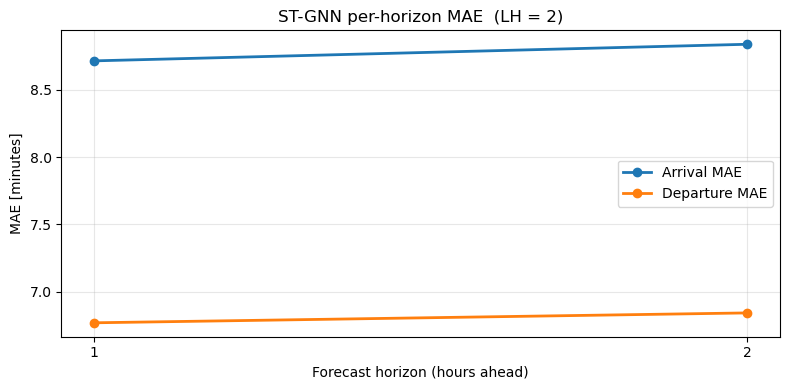

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# --------------------------------------------------
# 1)  Compute per-horizon MAE (masked)
# --------------------------------------------------
H            = y_true.shape[1]                 # look-ahead horizon
target_names = ["Arrival", "Departure"] if y_true.shape[-1] == 2 else ["Target"]
mae_per_h    = {name: [] for name in target_names}

for h in range(H):
    # Slice the h-th horizon → shape [B, N, D] → flatten to [B*N, D]
    yt_h = y_true[:, h, :, :].reshape(-1, y_true.shape[-1])
    yp_h = y_pred[:, h, :, :].reshape(-1, y_true.shape[-1])

    for i, name in enumerate(target_names):
        mask = yt_h[:, i] != 0.0          # skip padded rows
        mae_per_h[name].append(
            mean_absolute_error(yt_h[mask, i], yp_h[mask, i])
        )

# --------------------------------------------------
# 2)  Plot
# --------------------------------------------------
plt.figure(figsize=(8, 4))
x = np.arange(1, H + 1)                      # 1 … LH (hours ahead)

for name, mae_seq in mae_per_h.items():
    plt.plot(x, mae_seq, marker='o', lw=2, label=f"{name} MAE")

plt.title("ST-GNN per-horizon MAE  (LH = {})".format(H), fontsize=12)
plt.xlabel("Forecast horizon (hours ahead)")
plt.ylabel("MAE [minutes]")
plt.xticks(x)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import Counter

def top_k_airport_metrics(y_true, y_pred, airports, k=10):
    """
    Compute masked MAE/MSE/R² over only the k most-represented airports.
    
    y_true, y_pred : arrays  [B, H, N, D]
    airports       : list of length N (node index → IATA)
    """
    B, H, N, D = y_true.shape
    
    # 1) count how many valid (non-zero) rows each airport contributes
    valid_mask   = (y_true[..., 0] != 0.0)          # shape [B, H, N]
    counts_per_n = valid_mask.sum(axis=(0, 1))      # shape [N]
    
    # 2) take indices of the top-k airports
    top_idx = counts_per_n.argsort()[::-1][:k]
    top_iata = [airports[i] for i in top_idx]
    print("Top-{} airports: {}".format(k, ", ".join(top_iata)))
    
    # 3) gather only those nodes
    yt_top = y_true[:, :, top_idx, :].reshape(-1, D)
    yp_top = y_pred[:, :, top_idx, :].reshape(-1, D)
    
    # 4) masked metrics
    for i, label in enumerate(["Arrival", "Departure"] if D == 2 else ["Target"]):
        mask = yt_top[:, i] != 0.0                   # ignore padded zeros
        mae  = mean_absolute_error(yt_top[mask, i], yp_top[mask, i])
        mse  = mean_squared_error(yt_top[mask, i], yp_top[mask, i])
        r2   = r2_score        (yt_top[mask, i], yp_top[mask, i])
        print(f"{label:<9} | MAE: {mae:6.2f} | MSE: {mse:7.2f} | R²: {r2:6.3f}")

# -------------------------------------------
# usage
y_pred = model.predict(test_dataset, verbose=0)                # [B,H,N,D]
y_true_batches = [y.numpy() for (_, _), y in test_dataset
                  if y.shape[0] == batch_size]
y_true = np.concatenate(y_true_batches, axis=0)                # [B,H,N,D]

top_k_airport_metrics(y_true, y_pred, airports, k=10)


Top-10 airports: LAX, PHX, SFO, DEN, SEA, SLC, LAS, PDX, ATL, DFW
Arrival   | MAE:   8.53 | MSE:  143.52 | R²:  0.087
Departure | MAE:   6.71 | MSE:   99.84 | R²:  0.074


In [ ]:
import numpy as np

# Compute “valid” mask: True where the first target is non-zero (i.e. a real flight)
valid_mask   = (y_true[..., 0] != 0.0)    # shape [B, H, N]

# Count how many valid rows each airport has
counts_per_n = valid_mask.sum(axis=(0, 1))   # shape [N]

# Print the counts, sorted from largest to smallest
print("Test-set rows per airport (non-zero targets only):")
for iata, cnt in sorted(zip(airports, counts_per_n),
                        key=lambda x: x[1], reverse=True):
    print(f"{iata:5s}  {cnt:7d}")


Test-set rows per airport (non-zero targets only):
LAX       2982
PHX       2906
SFO       2860
DEN       2854
SEA       2832
SLC       2780
LAS       2762
PDX       2649
ATL       2615
DFW       2549
JFK       2547
ORD       2543
EWR       2529
PHL       2499
DCA       2487
MCO       2451
IAH       2443
BOS       2421
FLL       2415
IAD       2415
MIA       2411
SAN       2395
BWI       2383
MDW       2363
LGA       2359
CLT       2357
MCI       2345
STL       2341
AUS       2327
DTW       2321
BNA       2319
TPA       2279
MSY       2243
RDU       2237
HOU       2221
MSP       2179
SNA       2169


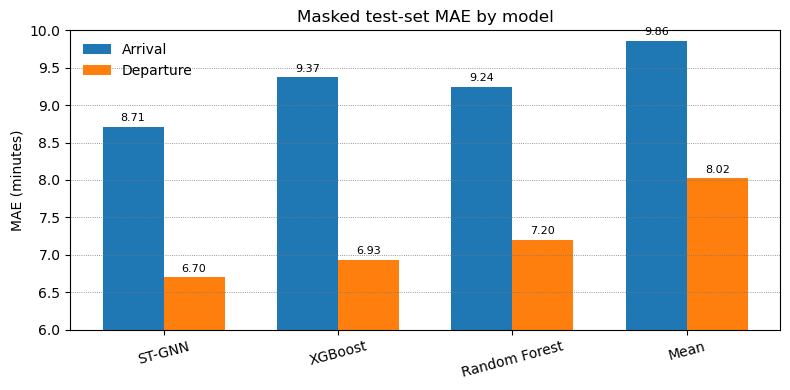

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ── your numbers ──────────────────────────────────────────────
models = ["ST-GNN", "XGBoost", "Random Forest",  "Mean"]
mae_arr = [8.71, 9.37, 9.24, 9.86]
mae_dep = [6.70, 6.93, 7.20, 8.02]

x = np.arange(len(models))
w = 0.35

fig, ax = plt.subplots(figsize=(8,4))

bars1 = ax.bar(x - w/2, mae_arr, w,  label="Arrival",   color="#1f77b4")
bars2 = ax.bar(x + w/2, mae_dep, w,  label="Departure", color="#ff7f0e")

# ── zoom y-axis & add grid ────────────────────────────────────
ax.set_ylim(6.0, 10.0)
ax.yaxis.grid(True, ls=":", lw=.6, c="#777")

# ── annotate exact values on each bar ─────────────────────────
for b in bars1+bars2:
    height = b.get_height()
    ax.text(b.get_x()+b.get_width()/2, height+0.05,
            f"{height:.2f}", ha='center', va='bottom', fontsize=8)

# ── cosmetics ─────────────────────────────────────────────────
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylabel("MAE (minutes)")
ax.set_title("Masked test-set MAE by model")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()


# chosing alpha

In [ ]:
""" import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


# ────────────────────────────────────────────────────────────────
# 0.  Functions you already have
#     • STGCN      – your network class (widths=(64,32,16))
#     • createDataset(X, A, Y, lookback, lookahead, batch_size)
#     • masked_mse / masked_mae (optional)
# ────────────────────────────────────────────────────────────────
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    ae   = tf.abs(y_true - y_pred) * mask
    return tf.reduce_sum(ae) / tf.reduce_sum(mask)

def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    se   = tf.square(y_true - y_pred) * mask
    return tf.reduce_sum(se) / tf.reduce_sum(mask)

# ────────────────────────────────────────────────────────────────
# 1.  Build a fresh compiled model (so every α starts from scratch)
# ────────────────────────────────────────────────────────────────
def build_stgcn():
    model = STGCN(num_nodes=N, num_features=F, num_labels=num_labels,
                  lookback=lookback, lookahead=lookahead,
                  dropout=dropout, l2_reg=l2_reg,
                  widths=(64, 32, 16))
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
        loss=masked_mse,             # or simply "mse"
        metrics=[masked_mae]           # or "mae"
    )
    return model

def edge_density(A_bin, eps=1e-6):
    N = A_bin.shape[0]
    return (A_bin > eps).sum() / (N*N)


def laplacian_smoothness(A, X):
    G = nx.from_numpy_array(A)
    L = nx.normalized_laplacian_matrix(G).A
    return np.trace(X.T @ L @ X)
# ────────────────────────────────────────────────────────────────
# 2.  Helper to build blended adjacency and datasets for 1 α
# ────────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split

def make_datasets_for_alpha(alpha,
                            X_train, A_dyn_train, A_stat3d_train, Y_train,
                            X_test,  A_dyn_test,  A_stat3d_test,  Y_test,
                            lookback, lookahead, batch_size):

    # ---  blend full-length adjacency ---------------------------------
    A_train_full = alpha * A_stat3d_train + (1 - alpha) * A_dyn_train
    A_test_full  = alpha * A_stat3d_test  + (1 - alpha) * A_dyn_test

    # ---  deterministic split  (last 20 % → validation) ---------------
    X_tr, X_val, A_tr, A_val, Y_tr, Y_val = train_test_split(
        X_train, A_train_full, Y_train, test_size=0.20, shuffle=False)

    # ---  build tf.data pipelines -------------------------------------
    train_ds = createDataset(X_tr,  A_tr,  Y_tr,  lookback, lookahead, batch_size)
    val_ds   = createDataset(X_val, A_val, Y_val, lookback, lookahead, batch_size)
    test_ds  = createDataset(X_test, A_test_full, Y_test,
                             lookback, lookahead, batch_size)

    # >>> return the extra raw tensors for metrics <<<
    return train_ds, val_ds, test_ds, X_val, A_val



# ────────────────────────────────────────────────────────────────
# 3.  Alpha sweep
# ────────────────────────────────────────────────────────────────
# ──────────────────────────────────────────────────────────────
# Laplacian-smoothness helper (one time-bin)
# ──────────────────────────────────────────────────────────────
import networkx as nx, numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf

def laplacian_smoothness(A_bin, X_bin):
    #Return tr(Xᵀ L X) for a single [N,N] adjacency & [N,F] feature slice
    L = nx.normalized_laplacian_matrix(nx.from_numpy_array(A_bin)).A
    return np.trace(X_bin.T @ L @ X_bin)


# ──────────────────────────────────────────────────────────────
# Alpha–sweep with smoothness
# ──────────────────────────────────────────────────────────────
# ... keep the previously shown imports and helpers ...

def sweep_alpha(alpha_grid,
                X_train,  A_dyn_train,  A_stat3d_train,  Y_train,
                X_test,   A_dyn_test,   A_stat3d_test,   Y_test,
                lookback, lookahead, batch_size,
                build_model_fn,
                make_datasets_fn,
                epochs=25, patience=6,
                eps=1e-6):                       # EPS for edge-density

    rows = []

    for alpha in alpha_grid:
        print(f"\n▶︎ α = {alpha:.2f}")

        train_ds, val_ds, test_ds, X_val_raw, A_val_raw = make_datasets_fn(
            alpha,
            X_train, A_dyn_train, A_stat3d_train, Y_train,
            X_test,  A_dyn_test,  A_stat3d_test,  Y_test,
            lookback, lookahead, batch_size)

        # ---- edge-density on the blended validation tensor
        dens_alpha = np.mean([edge_density(A_val_raw[i], eps=eps)
                              for i in range(A_val_raw.shape[0])])

        # ---- model training / evaluation (unchanged) -------------
        model = build_model_fn()
        early  = tf.keras.callbacks.EarlyStopping(
                     monitor="val_loss", patience=patience, restore_best_weights=True)
        reduce = tf.keras.callbacks.ReduceLROnPlateau(
                     monitor="val_loss", factor=0.5, patience=patience+1)

        hist = model.fit(train_ds, validation_data=val_ds,
                         epochs=epochs, callbacks=[early, reduce], verbose=0)

        best_val = float(np.min(hist.history["val_loss"]))
        test_mse, test_mae = model.evaluate(test_ds, verbose=0)

        y_pred = model.predict(test_ds, verbose=0)
        y_true = np.concatenate([y.numpy() for (_, _), y in test_ds], axis=0)
        yp, yt = y_pred.reshape(-1, y_pred.shape[-1]), y_true.reshape(-1, y_true.shape[-1])
        flat_mae, flat_r2 = mean_absolute_error(yt, yp), r2_score(yt, yp)

        smooth = np.mean([laplacian_smoothness(A_val_raw[i], X_val_raw[i])
                          for i in range(A_val_raw.shape[0])])

        rows.append({"alpha": alpha, "best_val": best_val,
                     "test_mae": test_mae, "flat_mae": flat_mae,
                     "flat_r2": flat_r2,   "smooth":  smooth,
                     "density": dens_alpha})

        print(f"   val {best_val:6.2f} | MAE {test_mae:5.2f} | "
              f"R² {flat_r2:6.3f} | S {smooth:7.2f} | ρ {dens_alpha:.3f}")

    return pd.DataFrame(rows).sort_values("best_val").reset_index(drop=True)



# ──────────────────────────────────────────────────────────────
# Example call
# ──────────────────────────────────────────────────────────────
alpha_grid = np.linspace(0.15, 0.45, 7)            # 0.15 … 0.45

alpha_results = sweep_alpha(
    alpha_grid,
    X_train, A_train, A_static3d_train, Y_train,
    X_test,  A_test,  A_static3d_test,  Y_test,
    lookback, lookahead, batch_size,
    build_model_fn=build_stgcn,           # <- your builder
    make_datasets_fn=make_datasets_for_alpha,
    epochs=20, patience=5)

print("\n===  SWEEP SUMMARY ===")
print(alpha_results.to_string(index=False))

 """

' import numpy as np\nimport pandas as pd\nimport tensorflow as tf\nfrom sklearn.metrics import mean_absolute_error, r2_score\nfrom sklearn.model_selection import train_test_split\n\n\n# ────────────────────────────────────────────────────────────────\n# 0.  Functions you already have\n#     • STGCN      – your network class (widths=(64,32,16))\n#     • createDataset(X, A, Y, lookback, lookahead, batch_size)\n#     • masked_mse / masked_mae (optional)\n# ────────────────────────────────────────────────────────────────\ndef masked_mae(y_true, y_pred):\n    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)\n    ae   = tf.abs(y_true - y_pred) * mask\n    return tf.reduce_sum(ae) / tf.reduce_sum(mask)\n\ndef masked_mse(y_true, y_pred):\n    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)\n    se   = tf.square(y_true - y_pred) * mask\n    return tf.reduce_sum(se) / tf.reduce_sum(mask)\n\n# ────────────────────────────────────────────────────────────────\n# 1.  Build a fresh compil

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# ------------------------------------------------------------------
# 0.  --- masked MAE / MSE helpers  (optional but recommended) -------
# ------------------------------------------------------------------
def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    ae   = tf.abs(y_true - y_pred) * mask
    return tf.reduce_sum(ae) / tf.reduce_sum(mask)

def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    se   = tf.square(y_true - y_pred) * mask
    return tf.reduce_sum(se) / tf.reduce_sum(mask)

# ------------------------------------------------------------------
# 1.  --- width-sweep runner ---------------------------------------
# ------------------------------------------------------------------
def sweep_widths(width_grid,
                 train_dataset, val_dataset, test_dataset,
                 num_nodes, num_features, num_labels,
                 lookback, lookahead,
                 dropout=0.1, l2_reg=1e-4,
                 epochs=50, batch_size=32,
                 lr=1e-3, patience=7,
                 loss_fn="mse",   # or masked_mse
                 metric_fn="mae"  # or masked_mae
                 ):
    """
    Train & evaluate one STGCN for every tuple in `width_grid`.

    Returns
    -------
    results_df : pd.DataFrame
        Columns: width, n_params, best_val, test_mse, test_mae, flat_mae, flat_r2
    histories  : dict
        Keras History objects keyed by width tuple.
    """
    results, histories = [], {}

    for widths in width_grid:
        print(f"\n▶︎▶︎  Training widths={widths}  ▶︎▶︎")

        model = STGCN(num_nodes=num_nodes,
                      num_features=num_features,
                      num_labels=num_labels,
                      lookback=lookback,
                      lookahead=lookahead,
                      dropout=dropout,
                      l2_reg=l2_reg,
                      widths=widths)

        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr),
                      loss=loss_fn,
                      metrics=[metric_fn])

        early = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=patience,
            restore_best_weights=True)
        lr_sched = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience+1)

        hist = model.fit(train_dataset,
                         validation_data=val_dataset,
                         epochs=epochs, callbacks=[early, lr_sched],
                         verbose=1)

        histories[widths] = hist

        # ---- evaluation on held-out test set ----------------------
        test_mse, test_mae = model.evaluate(test_dataset, verbose=0)

        # ---- flattened MAE / R² to mirror your current block ------
        y_pred = model.predict(test_dataset, verbose=0)
        y_true_batches = [y.numpy() for (_, _), y in test_dataset
                          if y.shape[0] == batch_size]
        y_true = np.concatenate(y_true_batches, axis=0)

        yp = y_pred.reshape(-1, y_pred.shape[-1])
        yt = y_true.reshape(-1, y_true.shape[-1])

        flat_mae = mean_absolute_error(yt, yp)
        flat_r2  = r2_score(yt, yp)

        n_params = model.count_params()
        best_val = np.min(hist.history["val_loss"])

        results.append({"width": widths,
                        "n_params": n_params,
                        "best_val": best_val,
                        "test_mse": test_mse,
                        "test_mae": test_mae,
                        "flat_mae": flat_mae,
                        "flat_r2":  flat_r2})

        print(f"  → best val {best_val:.4f} | "
              f"test_MAE {test_mae:.3f} | flat_R² {flat_r2:.3f}")

    results_df = pd.DataFrame(results).sort_values("best_val")
    return results_df, histories


## Channel width search

In [ ]:
"""    width_grid = [
     
  
Top 7
(128, 64, 32, 16),
 (64 , 32 , 16),
    (16, 32, 64, 128),
    (32, 64, 64, 32),
    (64, 64, 64),
    (64, 48, 24, 16),
    (32, 32, 32),
    (16, 64, 64),


# 4-block, “funnel” variants
    (64, 48, 24, 16),
    (64, 32, 32, 16),

    #orginal 4-
    (16, 32, 64, 128),
    (8, 16, 32, 64),

    # 4-block, symmetric plateau
    (32, 64, 64, 32),
    (24, 48, 48, 24),

    # 3-block, heavier mid-section
    (128, 64, 32, 16),
    (16, 64, 64),
    (16, 32, 64),
    (64, 64, 64),
    (32, 32, 32),
    (8, 16, 32)

    
  
   
   
] """


""" results_df, histories = sweep_widths(
    width_grid,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    num_nodes=N,
    num_features=F,
    num_labels=num_labels,
    lookback=lookback,
    lookahead=lookahead,
    dropout=dropout,
    l2_reg=l2_reg,
    epochs=100,          # shorten for a quick sweep
    batch_size=batch_size,
    lr=1e-3,
    patience=15,
    loss_fn=masked_mse,   # or "mse"
    metric_fn=masked_mae  # or "mae"
)

print("\n===  SWEEP SUMMARY  ===")
print(results_df.to_string(index=False)) """


' results_df, histories = sweep_widths(\n    width_grid,\n    train_dataset=train_dataset,\n    val_dataset=val_dataset,\n    test_dataset=test_dataset,\n    num_nodes=N,\n    num_features=F,\n    num_labels=num_labels,\n    lookback=lookback,\n    lookahead=lookahead,\n    dropout=dropout,\n    l2_reg=l2_reg,\n    epochs=100,          # shorten for a quick sweep\n    batch_size=batch_size,\n    lr=1e-3,\n    patience=15,\n    loss_fn=masked_mse,   # or "mse"\n    metric_fn=masked_mae  # or "mae"\n)\n\nprint("\n===  SWEEP SUMMARY  ===")\nprint(results_df.to_string(index=False)) '

## MEA and r2 for each airport

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# -----------------------------------------------------------------
# 0️⃣  Make sure y_pred has the same shape as y_true
# -----------------------------------------------------------------
Yt = np.concatenate(y_true_batches, axis=0)         # -> (B, H, N, D)
Yp = y_pred                                         # model.predict already returns (B,H,N,D)

B, H, N, D = Yt.shape
labels = ["Arrival", "Departure"] if D == 2 else ["Target"]

# -----------------------------------------------------------------
#  CHOOSE ONE of the following three strategies
# -----------------------------------------------------------------

## (a) *Next-hour only*  ― most common
#h_idx = 0                                 # <-- set 0,1,2 for t+1, t+2, …
#Yt_h = Yt[:, h_idx, :, :].reshape(-1, N, D)
#Yp_h = Yp[:, h_idx, :, :].reshape(-1, N, D)
#suffix = f"(h={h_idx+1})"

## (b) *Flatten all horizons into one big time-axis*
Yt_h = Yt.reshape(-1, N, D)
Yp_h = Yp.reshape(-1, N, D)
suffix = "(all h merged)"

## (c) *Loop over horizons separately* (uncomment the loop at the bottom instead)
#Yt_h = Yt      # keep 4-D
#Yp_h = Yp
#suffix = ""    # handled inside the loop


# -----------------------------------------------------------------
#  Pick top-k airports by “how often they appear with a non-zero target”
# -----------------------------------------------------------------
nonzero = (Yt_h != 0).any(axis=2)          # (T*, N) boolean
active_counts = nonzero.sum(axis=0)        # (N,)
topk = 37
top_idx = np.argsort(active_counts)[-topk:][::-1]
top_codes = [airports[i] for i in top_idx]

# -----------------------------------------------------------------
#  Metric table
# -----------------------------------------------------------------
# -----------------------------------------------------------------
rows = []
for i, code in zip(top_idx, top_codes):
    for d in range(D):
        yt = Yt_h[:, i, d]
        yp = Yp_h[:, i, d]
        mae = mean_absolute_error(yt, yp)
        r2  = r2_score(yt, yp)
        std = np.std(yt)

        rows.append({
            "Airport": code,
            "Target" : labels[d] if D == 2 else f"Y{d}",
            "Horizon": suffix,
            "MAE"    : mae,
            "R²"     : r2,
            "True σ": std
        })

df = pd.DataFrame(rows)
print("\n=====  PER-AIRPORT METRICS", suffix, "=====")
print(df.to_string(index=False))

# -----------------------------------------------------------------
# 4️⃣  (Optional)  loop over horizons separately
# -----------------------------------------------------------------
#for h_idx in range(H):
#    Yt_h = Yt[:, h_idx, :, :].reshape(-1, N, D)
#    Yp_h = Yp[:, h_idx, :, :].reshape(-1, N, D)
#    #...  # reuse the rows-building loop above, adding "H=h_idx+1" to Horizon
  




=====  PER-AIRPORT METRICS (all h merged) =====
Airport    Target        Horizon       MAE        R²    True σ
    LAX   Arrival (all h merged)  7.783727  0.031045 10.813853
    LAX Departure (all h merged)  6.086513  0.065608  9.046653
    PHX   Arrival (all h merged)  7.420155  0.048311 10.694131
    PHX Departure (all h merged)  5.604196  0.126881  8.993305
    SFO   Arrival (all h merged) 10.228362  0.000797 14.319046
    SFO Departure (all h merged)  8.771393 -0.047672 13.244794
    DEN   Arrival (all h merged)  9.319587  0.056198 14.675722
    DEN Departure (all h merged)  6.772802  0.084858 10.995024
    SEA   Arrival (all h merged)  8.396226 -0.004869 10.893041
    SEA Departure (all h merged)  6.059420  0.007459  8.273995
    SLC   Arrival (all h merged)  8.871449  0.058503 12.398464
    SLC Departure (all h merged)  6.948048  0.021496 10.165015
    LAS   Arrival (all h merged)  8.326619  0.092618 12.051584
    LAS Departure (all h merged)  6.464979  0.157798 10.575233
    PD

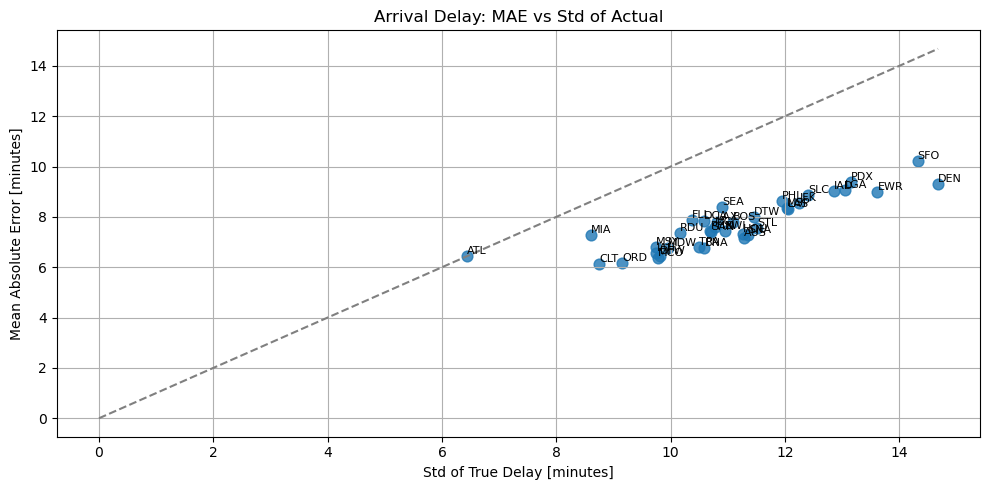

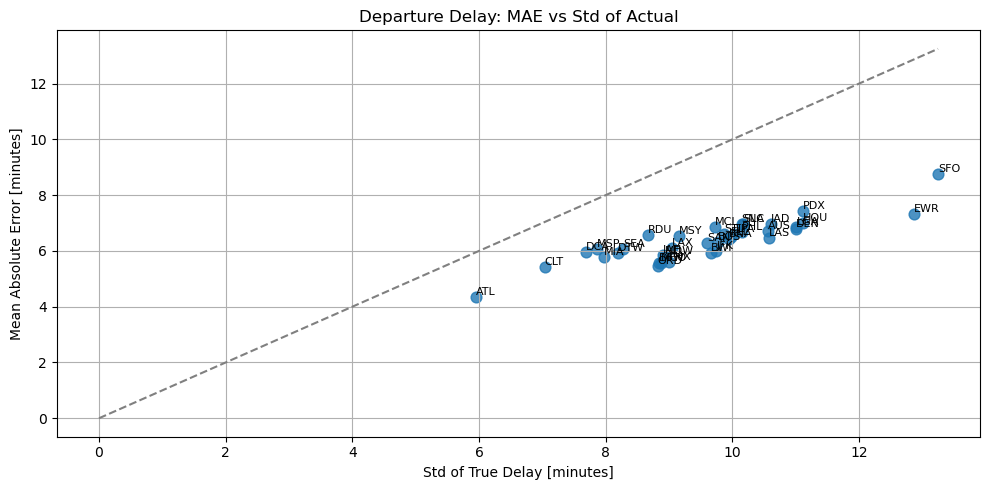

In [ ]:
import matplotlib.pyplot as plt

# Filter: top airports by frequency (already top_idx)
top_airport_df = df[df["Airport"].isin(top_codes)]

# Separate plots for Arrival and Departure
for target in labels:
    subset = top_airport_df[top_airport_df["Target"] == target]

    plt.figure(figsize=(10, 5))
    plt.scatter(subset["True σ"], subset["MAE"], s=60, alpha=0.8)
    
    # Optional: add identity line
    max_val = max(subset["True σ"].max(), subset["MAE"].max())
    plt.plot([0, max_val], [0, max_val], linestyle="--", color="gray")

    # Labels and annotations
    for _, row in subset.iterrows():
        plt.text(row["True σ"], row["MAE"], row["Airport"],
                 fontsize=8, ha='left', va='bottom')

    plt.title(f"{target} Delay: MAE vs Std of Actual")
    plt.xlabel("Std of True Delay [minutes]")
    plt.ylabel("Mean Absolute Error [minutes]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## xgboost

In [ ]:
import numpy as np, pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
def flatten_xy_single(X, Y, target_idx):
    """
    X  : [T, N, F]
    Y  : [T, N, D]
    returns  (X_flat, y_flat)  with valid (=non-zero) rows only
    """
    Xf = X.reshape(-1, X.shape[-1])               # (T·N, F)
    yf = Y[..., target_idx].reshape(-1)           # (T·N, )
    mask = yf != 0.0                              # keep real flights
    return Xf[mask], yf[mask]

def train_and_report(X_tr, y_tr, X_te, y_te, label):
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_te_s = scaler.transform(X_te)

    model = XGBRegressor(
        n_estimators=500, max_depth=10, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=10,
        reg_lambda=10, objective="reg:squarederror", n_jobs=-1,
        random_state=42
    ).fit(X_tr_s, y_tr)
 
    y_hat = model.predict(X_te_s)
    print(f"\n{label} — XGBoost")
    print(f"MAE  {mean_absolute_error(y_te, y_hat):6.2f}")
    print(f"MSE  {mean_squared_error(y_te, y_hat):6.2f}")
    print(f"R²   {r2_score(y_te, y_hat):7.3f}")
    return model

# ------------------------------------------------------------------
# Run once for Arrival, once for Departure
# ------------------------------------------------------------------
for idx, lbl in zip([0, 1], ["Arrival", "Departure"]):
    X_tr_flat, y_tr = flatten_xy_single(X_train, Y_train, target_idx=idx)
    X_te_flat, y_te = flatten_xy_single(X_test , Y_test , target_idx=idx)

    _ = train_and_report(X_tr_flat, y_tr, X_te_flat, y_te, lbl)





Arrival — XGBoost
MAE    9.37
MSE  153.12
R²     0.021

Departure — XGBoost
MAE    6.93
MSE   97.13
R²     0.131


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# ──────────────────────────────────────────────────────────────
# 1. helper – flatten one target channel and mask padded rows
# ──────────────────────────────────────────────────────────────
def flatten_xy_single(X, Y_single):
    """
    X         : [T, N, F]
    Y_single  : [T, N]  (one target only)
    returns   : X_flat, y_flat   with padded rows removed
    """
    X_flat = X.reshape(-1, X.shape[-1])   # (T·N, F)
    y_flat = Y_single.reshape(-1)         # (T·N,)
    keep   = y_flat != 0.0                # True = real flight
    return X_flat[keep], y_flat[keep]


# ──────────────────────────────────────────────────────────────
# 2. helper – fit model and print masked metrics
# ──────────────────────────────────────────────────────────────
def fit_and_report(model, X_tr, y_tr, X_te, y_te, label):
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)

    mae = mean_absolute_error(y_te, y_hat)
    mse = mean_squared_error(y_te, y_hat)
    r2  = r2_score(y_te, y_hat)

    print(f"{label:<11} MAE: {mae:6.2f}  |  MSE: {mse:7.2f}  |  R²: {r2:6.3f}")
    return mae, mse, r2


# ──────────────────────────────────────────────────────────────
# 3. prepare flattened data for Arrival *and* Departure
# ──────────────────────────────────────────────────────────────
# Arrival  = Y[..., 0];   Departure = Y[..., 1]
X_arr_tr, y_arr_tr = flatten_xy_single(X_train, Y_train[:, :, 0])
X_arr_te, y_arr_te = flatten_xy_single(X_test , Y_test [:, :, 0])

X_dep_tr, y_dep_tr = flatten_xy_single(X_train, Y_train[:, :, 1])
X_dep_te, y_dep_te = flatten_xy_single(X_test , Y_test [:, :, 1])

print("Arrival rows   :", len(y_arr_tr), "train  |", len(y_arr_te), "test")
print("Departure rows :", len(y_dep_tr), "train  |", len(y_dep_te), "test")


# ──────────────────────────────────────────────────────────────
# 4.  models
#     • we wrap each estimator in a Standard-Scaler pipeline
# ──────────────────────────────────────────────────────────────
rf   = make_pipeline(StandardScaler(with_mean=False),  # trees aren't scale-sensitive but good practise
                     RandomForestRegressor(n_estimators=200,
                                           max_depth=None,
                                           n_jobs=-1,
                                           random_state=42))

lin  = make_pipeline(LinearRegression())
mean = DummyRegressor(strategy="mean")


# ──────────────────────────────────────────────────────────────
# 5.  train & report
# ──────────────────────────────────────────────────────────────
print("\n----  RANDOM FOREST  ----")
#fit_and_report(rf,  X_arr_tr, y_arr_tr, X_arr_te, y_arr_te, "Arrival")
#fit_and_report(rf,  X_dep_tr, y_dep_tr, X_dep_te, y_dep_te, "Departure")

print("\n----  LINEAR REGRESSION  ----")
fit_and_report(lin, X_arr_tr, y_arr_tr, X_arr_te, y_arr_te, "Arrival")
fit_and_report(lin, X_dep_tr, y_dep_tr, X_dep_te, y_dep_te, "Departure")

print("\n----  MEAN BASELINE  ----")
fit_and_report(mean, X_arr_tr, y_arr_tr, X_arr_te, y_arr_te, "Arrival")
fit_and_report(mean, X_dep_tr, y_dep_tr, X_dep_te, y_dep_te, "Departure")


Arrival rows   : 188208 train  | 47057 test
Departure rows : 188176 train  | 46999 test

----  RANDOM FOREST  ----

----  LINEAR REGRESSION  ----
Arrival     MAE:   8.70  |  MSE:  139.12  |  R²:  0.110
Departure   MAE:   6.68  |  MSE:   95.44  |  R²:  0.146

----  MEAN BASELINE  ----
Arrival     MAE:   9.86  |  MSE:  163.38  |  R²: -0.044
Departure   MAE:   8.02  |  MSE:  114.12  |  R²: -0.021


(8.02, 114.1, -0.021033972758560227)

## feature importance for xgboost, when 1 target

In [ ]:
""" # ----------------------------------------
# 1) Make sure feature_names are in order
# ----------------------------------------
try:
    # If you already have a pandas DataFrame X_tr_flat with columns
    feature_names = X_train.columns      # or whatever DF you used
except AttributeError:
    # If X_tr_flat is a NumPy array, fabricate labels “f0 … f37”
    feature_names = [f"f{i}" for i in range(X_tr_flat.shape[1])]

# ----------------------------------------
# 2) Define the helper just once
# ----------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(
    model,
    feature_names,
    top_n: int = 20,
    title: str = "Top 20 Most Important Features",
    importance_type: str = "gain",
):
    raw_imp = model.get_booster().get_score(importance_type=importance_type)

    # map f17 -> real name
    imp = {feature_names[int(k[1:])] if k.startswith("f") else k: v
           for k, v in raw_imp.items()}

    full_df = (pd.DataFrame({
                  "feature": feature_names,
                  "importance": [imp.get(col, 0.0) for col in feature_names]
               })
               .sort_values("importance", ascending=False))

    top_df = full_df.head(top_n).reset_index(drop=True)

    # bar chart
    plt.figure(figsize=(8, top_n * 0.4))
    plt.barh(top_df["feature"][::-1], top_df["importance"][::-1])
    plt.title(title); plt.xlabel(importance_type.capitalize()); plt.tight_layout()
    plt.show()

    return top_df

# ----------------------------------------
# 3) Call it on your fitted XGB model
# ----------------------------------------
# Make sure feature_cols matches X_tr_flat column order
feature_names = feature_cols            # e.g. length 38
importance_df = plot_feature_importance(
    model=xgb,                            # ← your trained model
    #feature_names=feature_names,
    top_n=20,
    title="Top 20 Most Important Features (XGB)"
)

print("\nTop-20 importance table:")
display(importance_df)
 """

' # ----------------------------------------\n# 1) Make sure feature_names are in order\n# ----------------------------------------\ntry:\n    # If you already have a pandas DataFrame X_tr_flat with columns\n    feature_names = X_train.columns      # or whatever DF you used\nexcept AttributeError:\n    # If X_tr_flat is a NumPy array, fabricate labels “f0 … f37”\n    feature_names = [f"f{i}" for i in range(X_tr_flat.shape[1])]\n\n# ----------------------------------------\n# 2) Define the helper just once\n# ----------------------------------------\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ndef plot_feature_importance(\n    model,\n    feature_names,\n    top_n: int = 20,\n    title: str = "Top 20 Most Important Features",\n    importance_type: str = "gain",\n):\n    raw_imp = model.get_booster().get_score(importance_type=importance_type)\n\n    # map f17 -> real name\n    imp = {feature_names[int(k[1:])] if k.startswith("f") else k: v\n           for k, v in raw_imp.item

## airport specific actual / predict test

results.shape = (56832, 10)


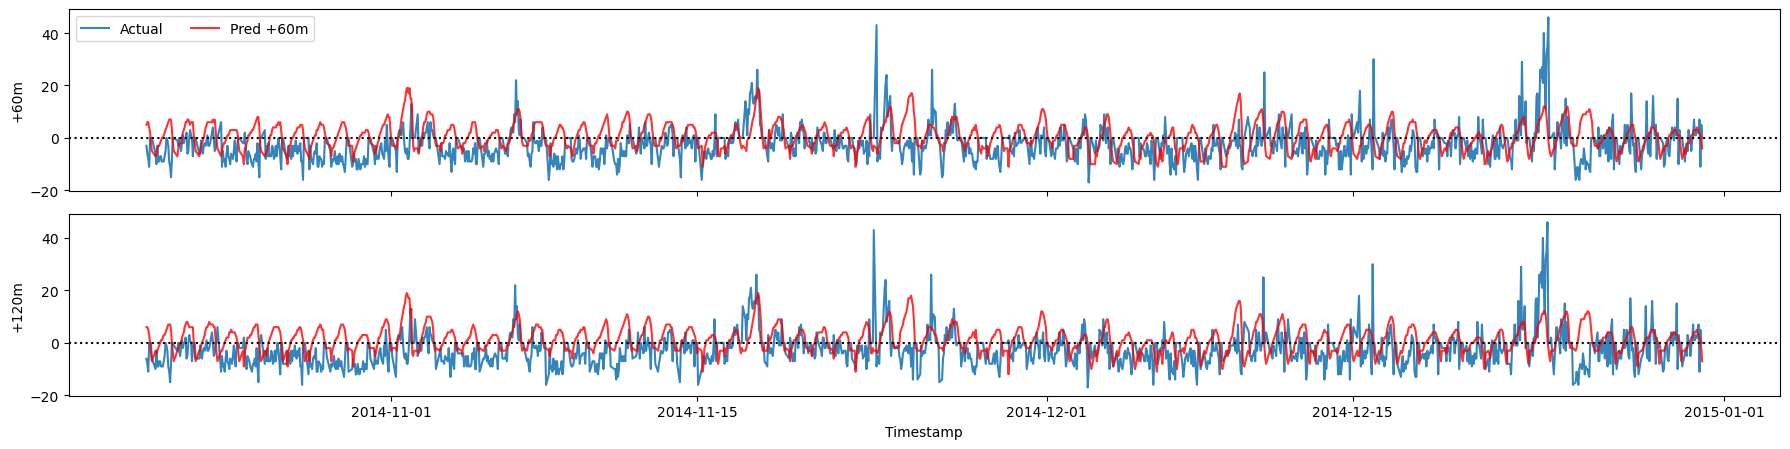

In [ ]:
buffers   = []
windows   = y_pred.shape[0]
rows_idx  = np.arange(lookback, lookback + windows)
H         = lookahead 

horiz_cols = [f"{60*(h+1)}m" for h in range(H)]

for node, ap in enumerate(airports):
    times     = [test_bins[t] for t in rows_idx]
    arr_true  = np.stack([Y_test[rows_idx + h, node, 0] for h in range(H)], axis=1)
    dep_true  = np.stack([Y_test[rows_idx + h, node, 1] for h in range(H)], axis=1)
    arr_pred  = y_pred[:, :H, node, 0]
    dep_pred  = y_pred[:, :H, node, 1]

    df_ap = pd.concat(
        [pd.Series(times, name="time"),
         pd.DataFrame(arr_true.round().astype(int), columns=[f"arr_{c}"     for c in horiz_cols]),
         pd.DataFrame(dep_true.round().astype(int), columns=[f"dep_{c}"     for c in horiz_cols]),
         pd.DataFrame(arr_pred.round().astype(int), columns=[f"arr_est_{c}" for c in horiz_cols]),
         pd.DataFrame(dep_pred.round().astype(int), columns=[f"dep_est_{c}" for c in horiz_cols])
         ],
        axis=1).assign(airport=ap)
    buffers.append(df_ap)

results = pd.concat(buffers, ignore_index=True)
print("results.shape =", results.shape)

# quick horizon plot for one airport
airport = "ATL"
df = results.query('airport == @airport').reset_index(drop=True)
fig, axes = plt.subplots(H, 1, figsize=(18, 2.3*H), sharex=True, sharey=True)
for ax, mins in zip(axes, [60*(h+1) for h in range(H)]):
    ax.plot(df["time"], df[f"arr_{mins}m"], label="Actual", alpha=0.9)
    ax.plot(df["time"], df[f"arr_est_{mins}m"], color="r", label=f"Pred +{mins}m", alpha=0.8)
    ax.axhline(0, ls=":", color="k")
    if mins == 60: ax.legend(ncol=2)
    ax.set_ylabel(f"+{mins}m")
axes[-1].set_xlabel("Timestamp"); plt.tight_layout(); plt.show()

# Most popular airports

Top-5 airports: ['LAX', 'PHX', 'SFO', 'DEN', 'SEA', 'SLC', 'LAS', 'PDX', 'ATL', 'DFW']
results.shape = (15360, 10)


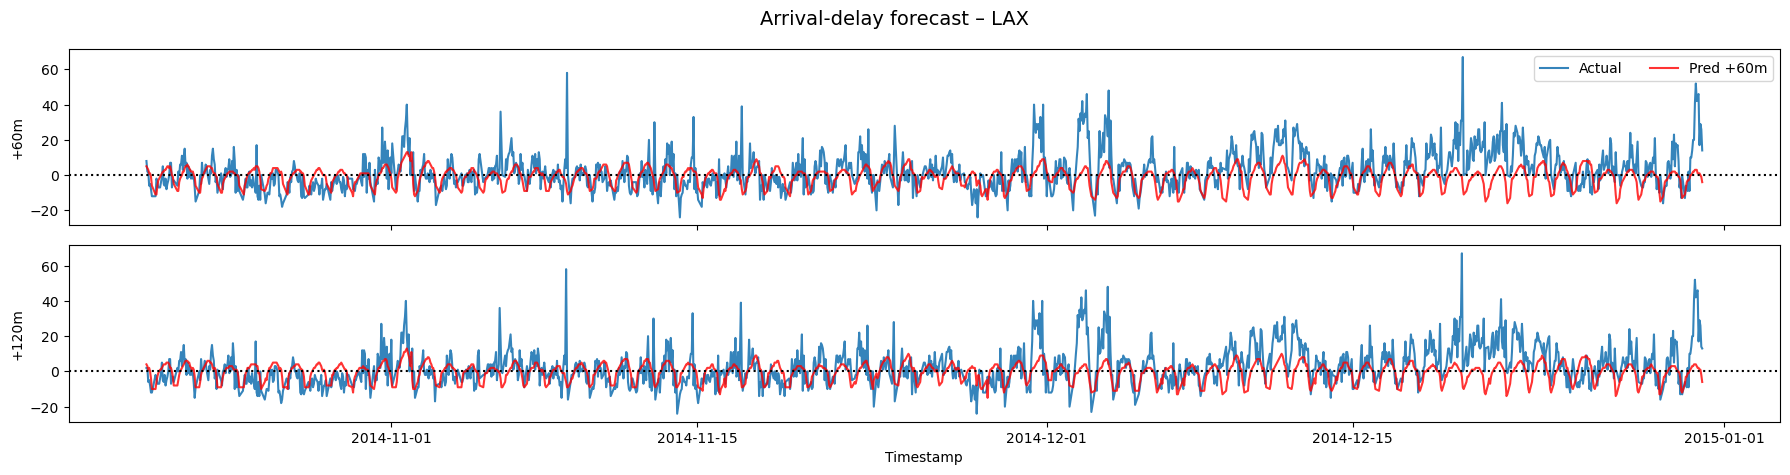

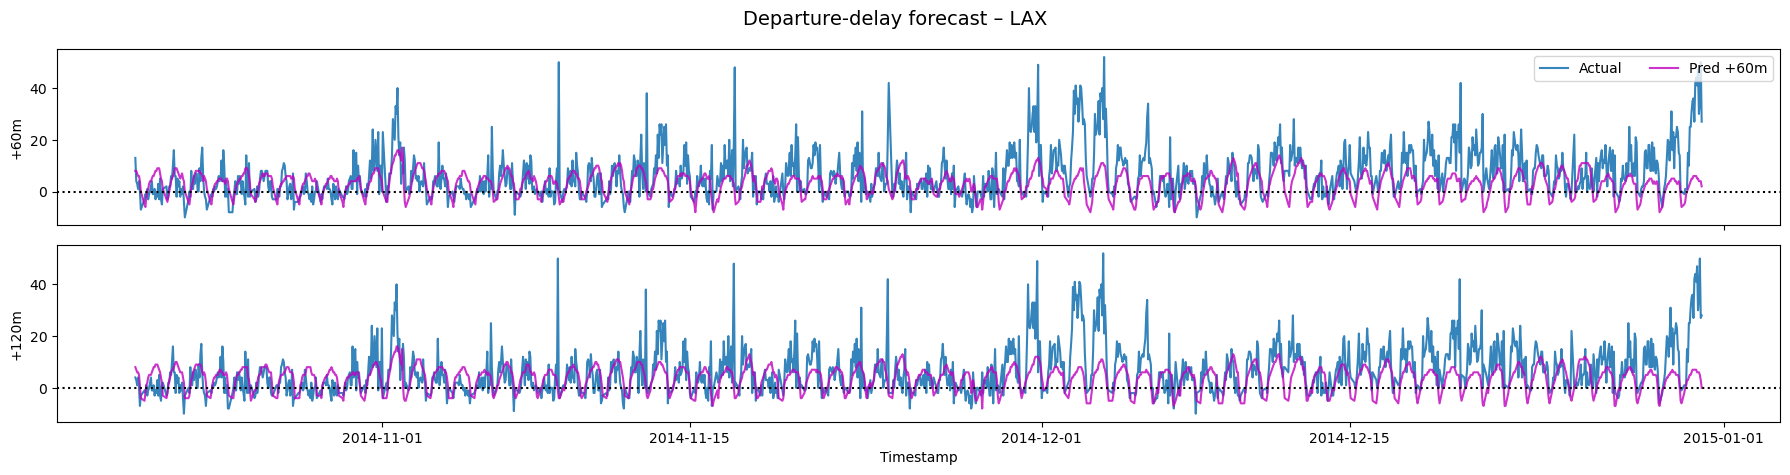

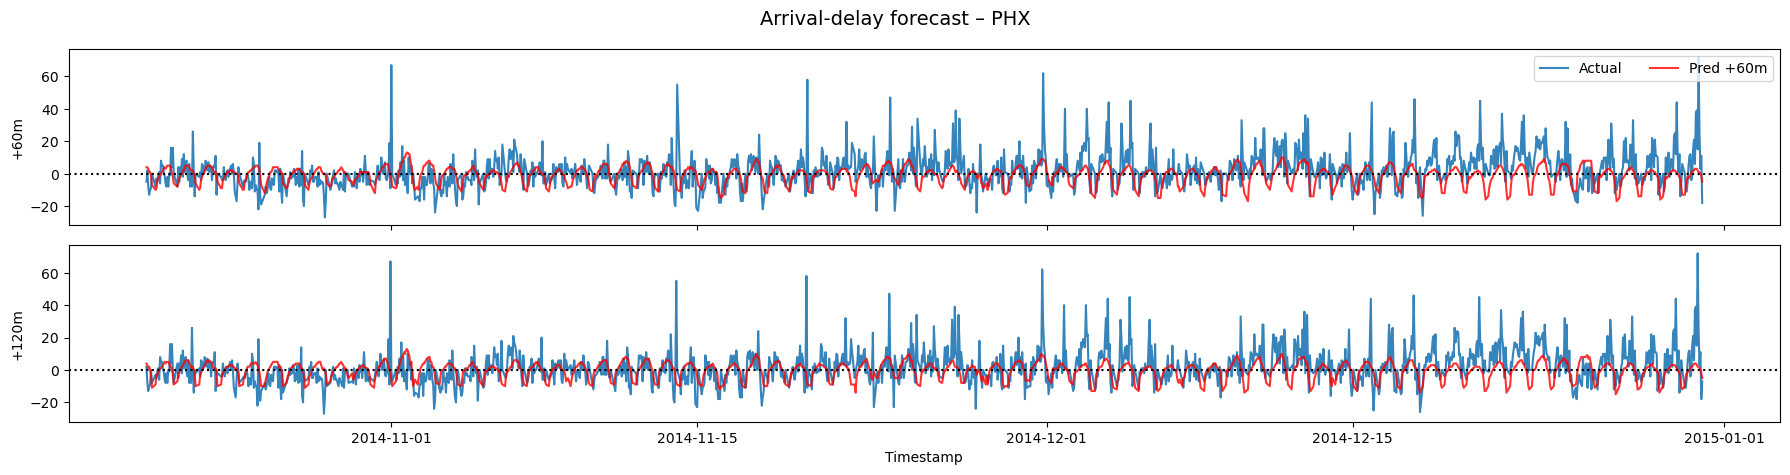

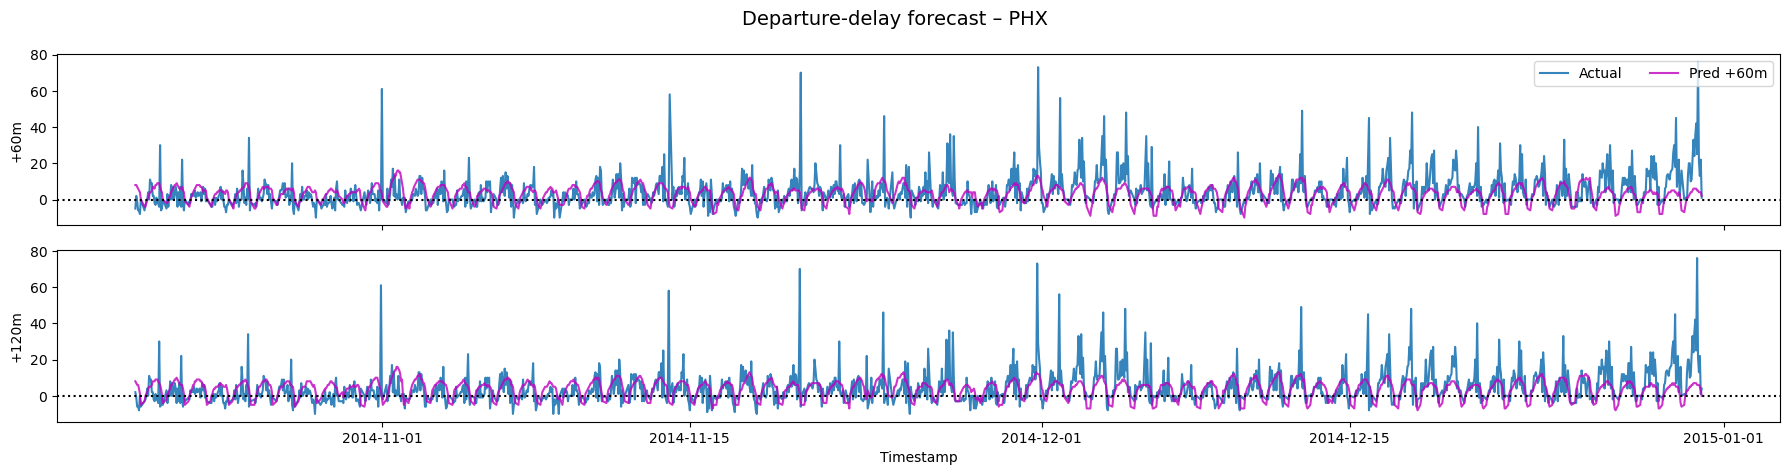

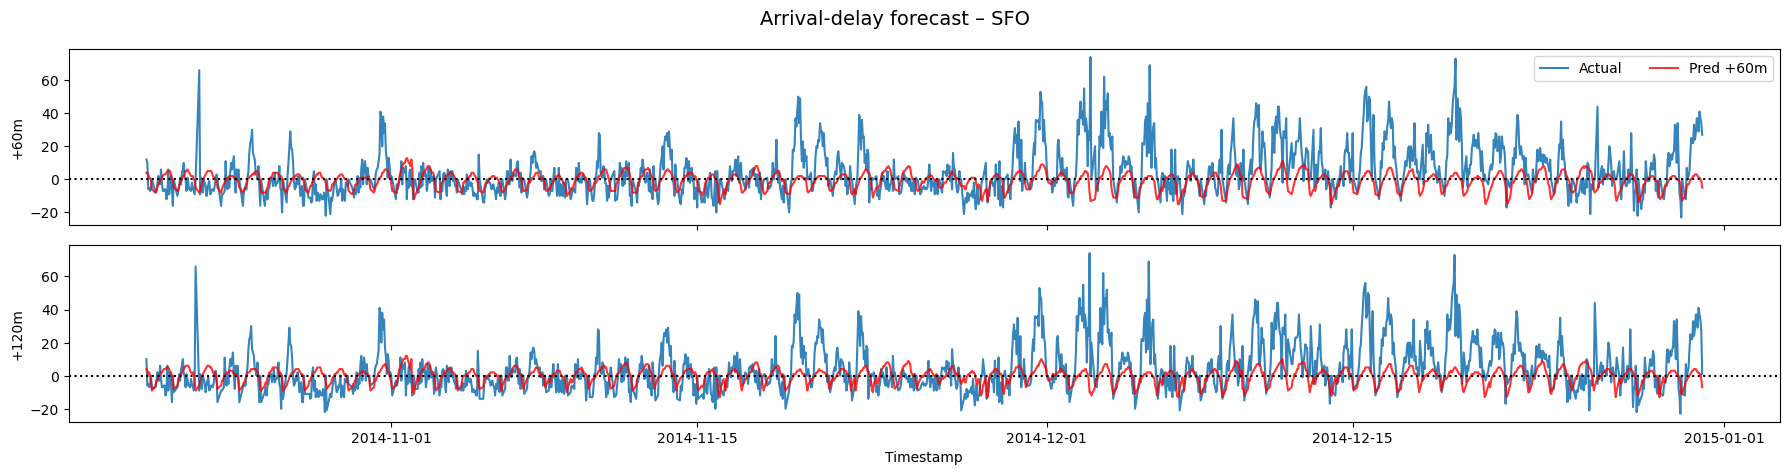

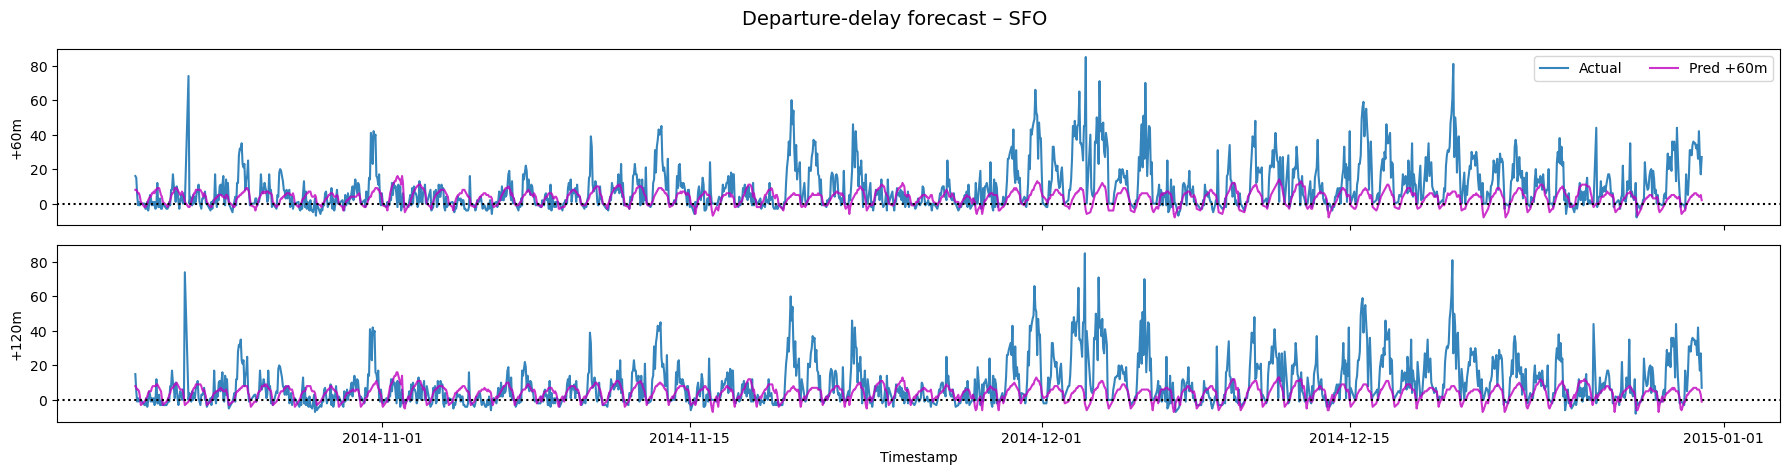

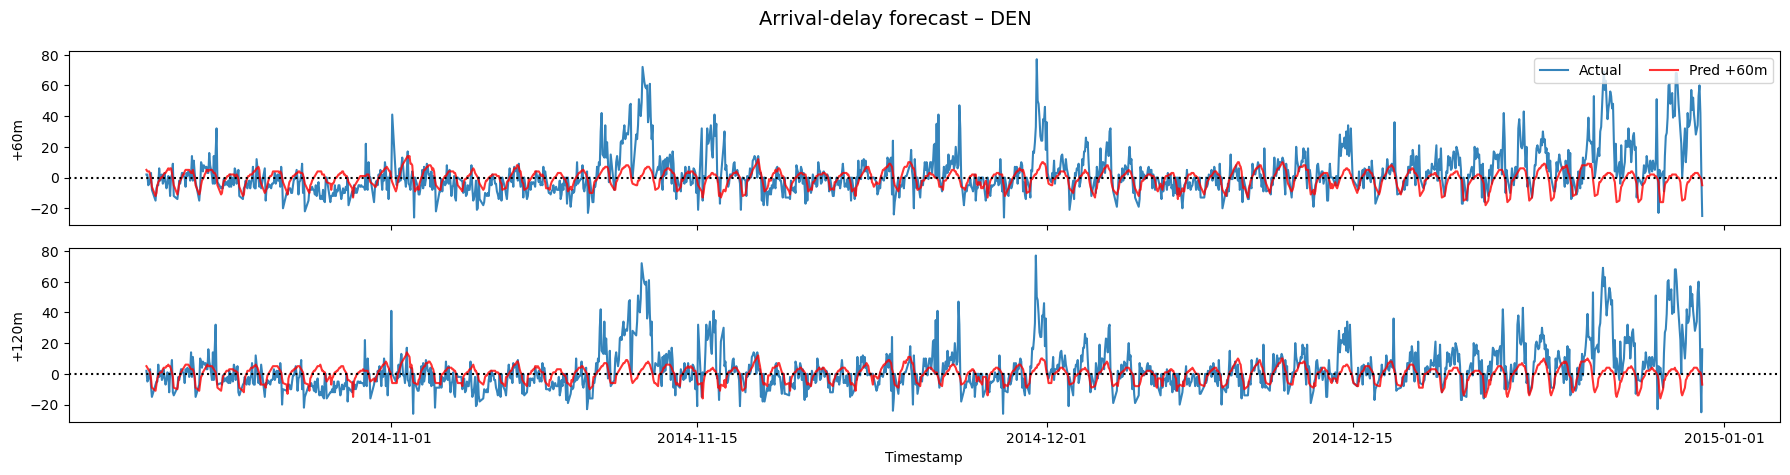

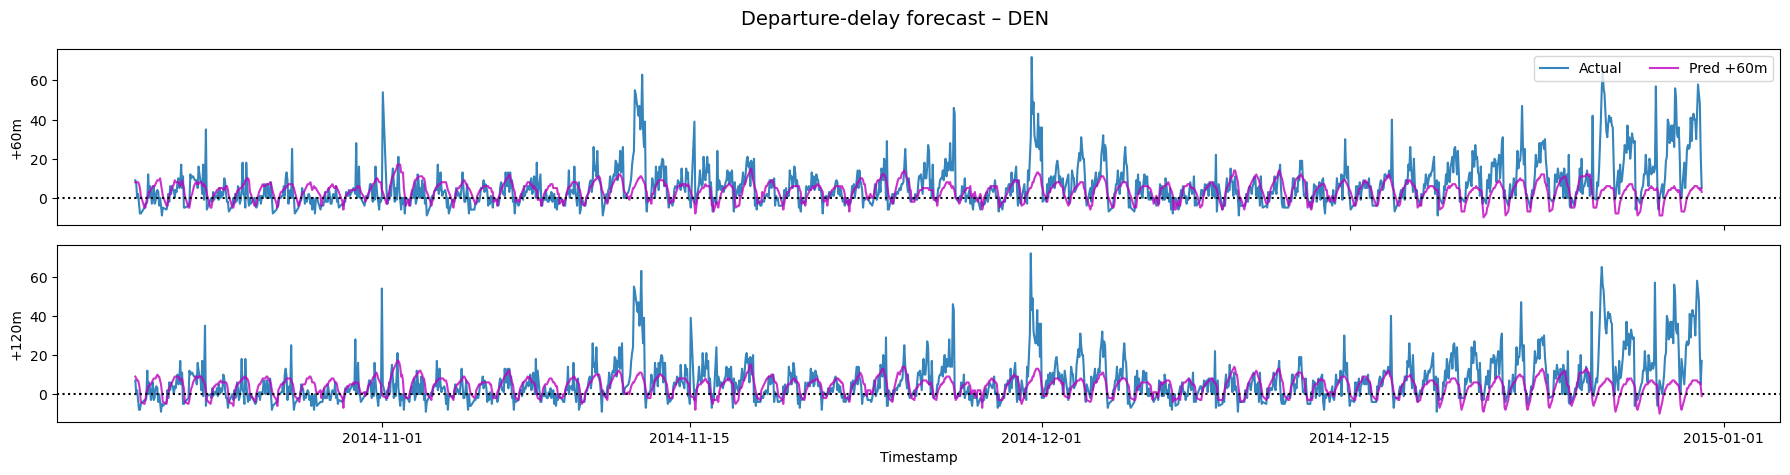

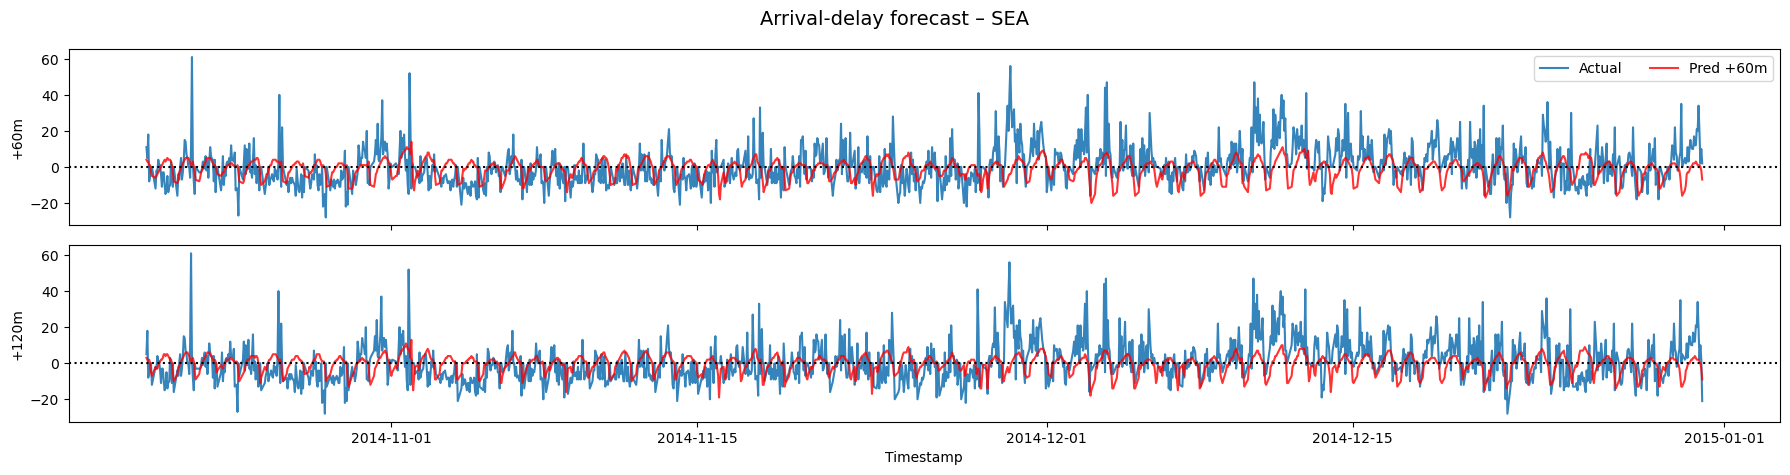

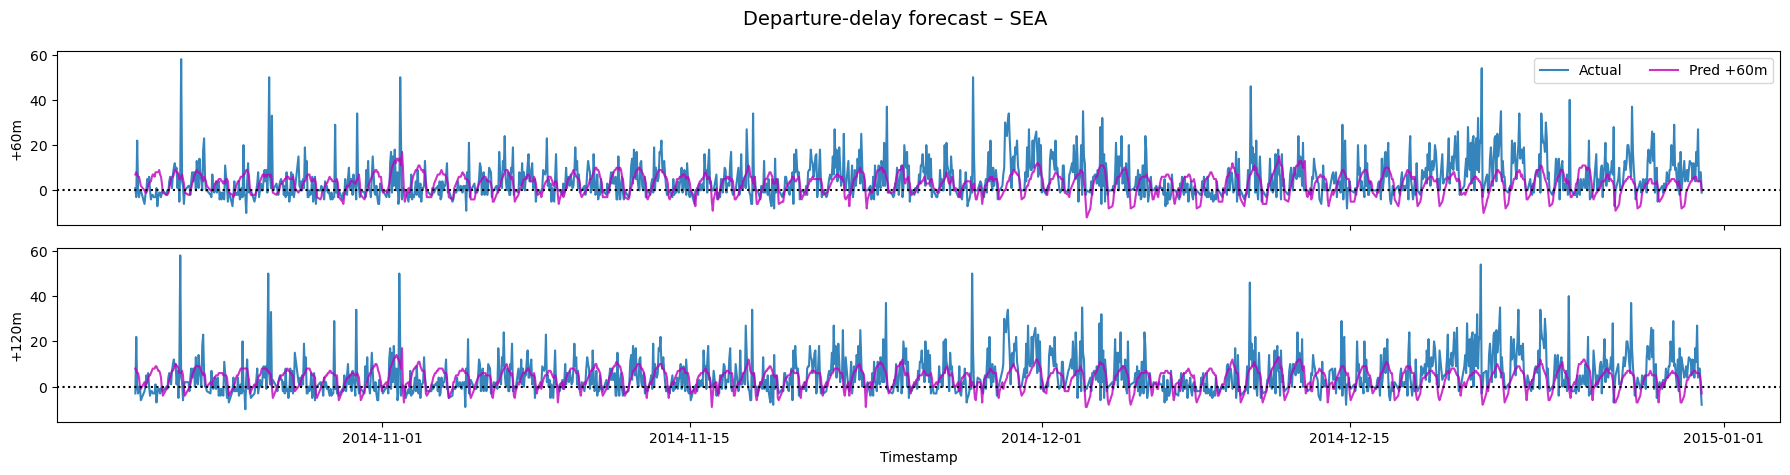

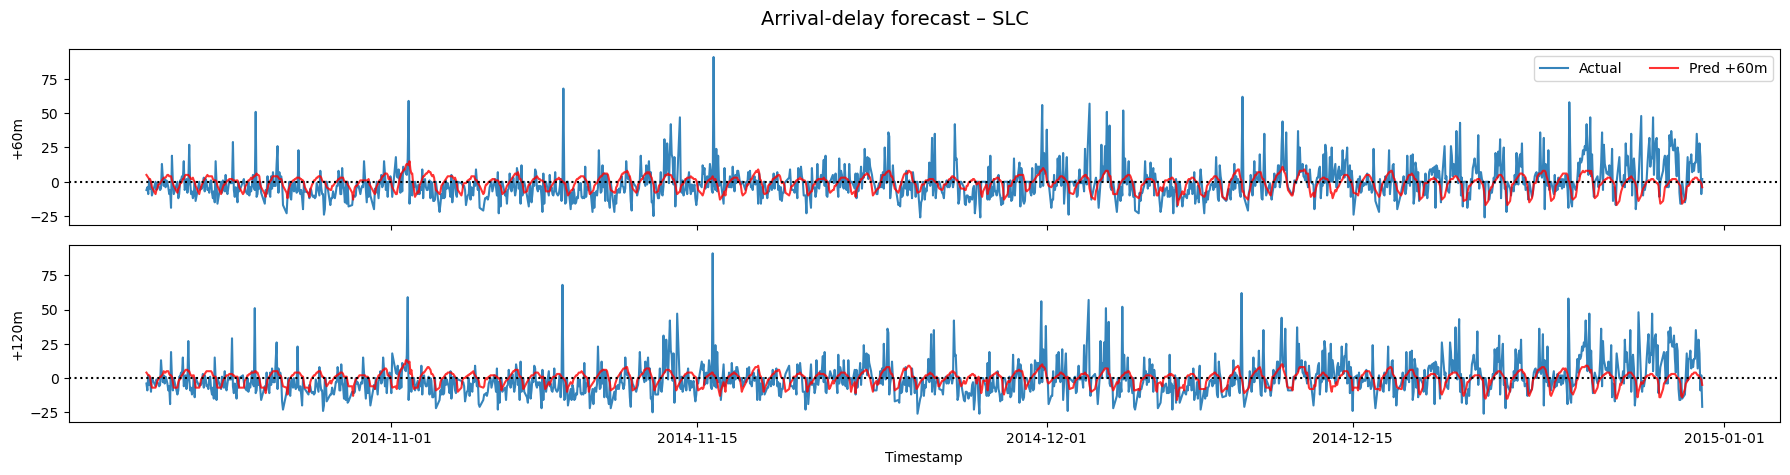

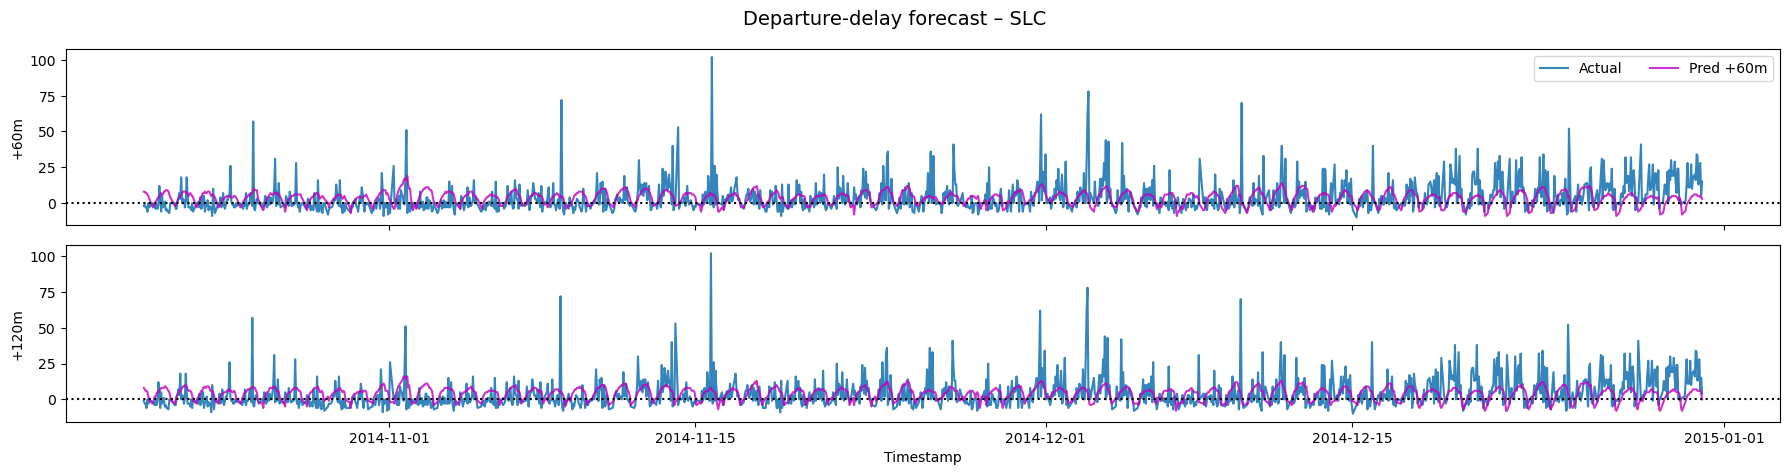

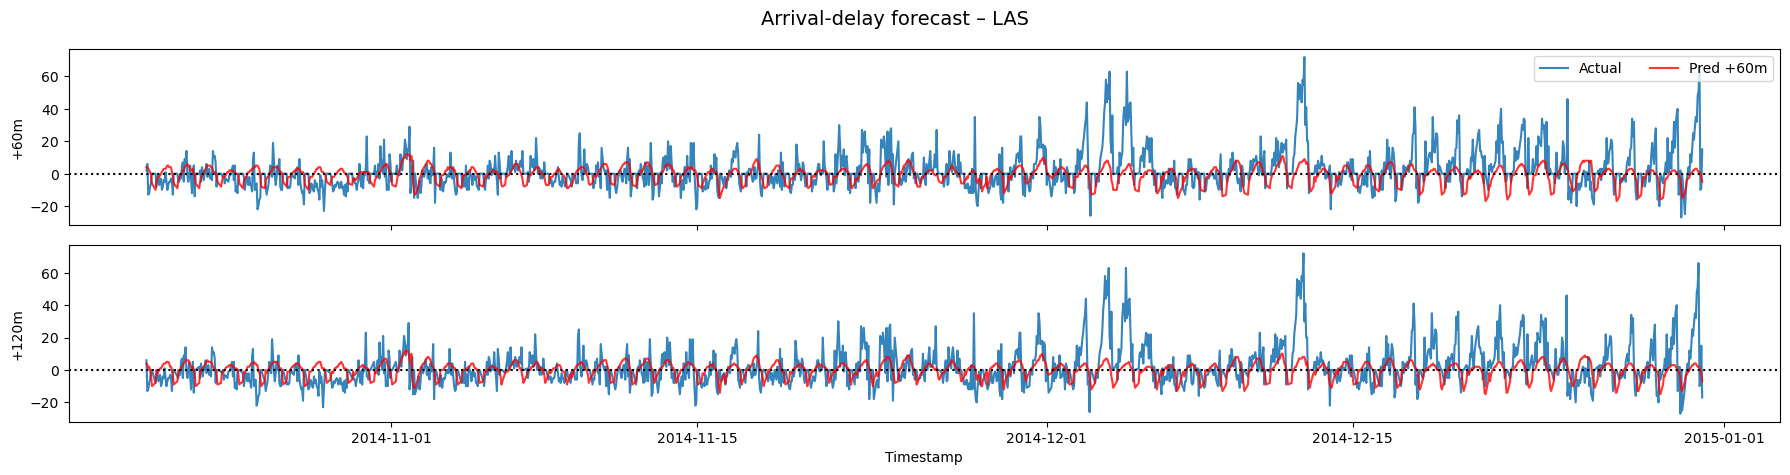

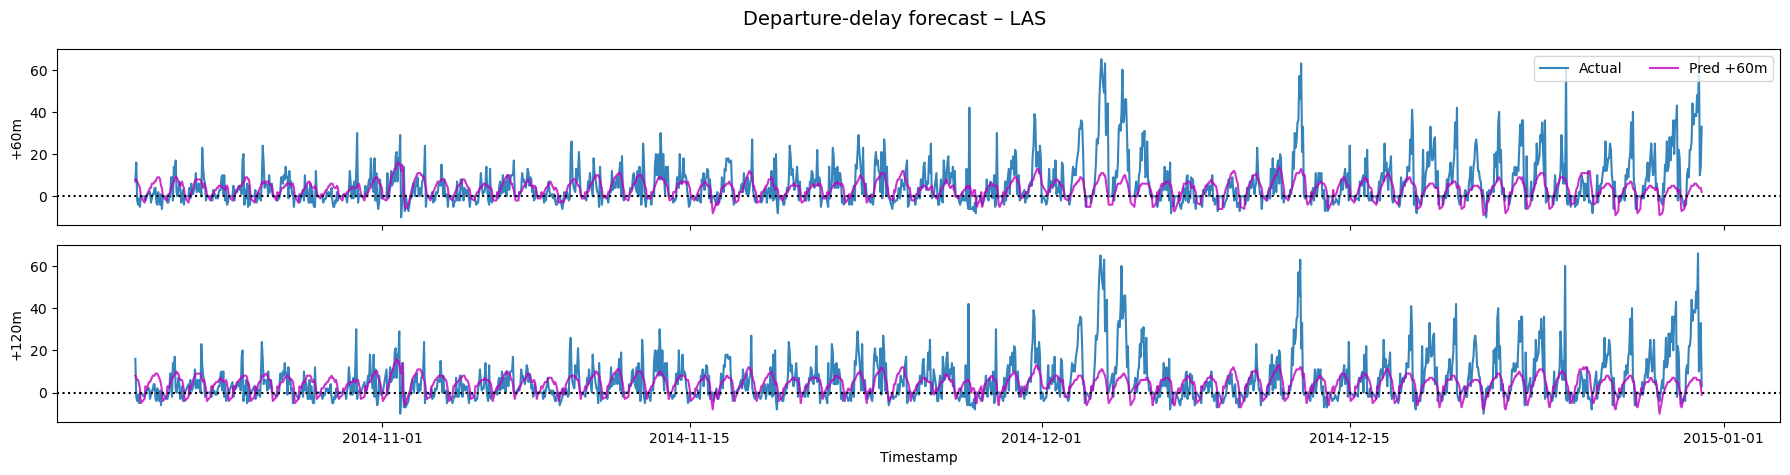

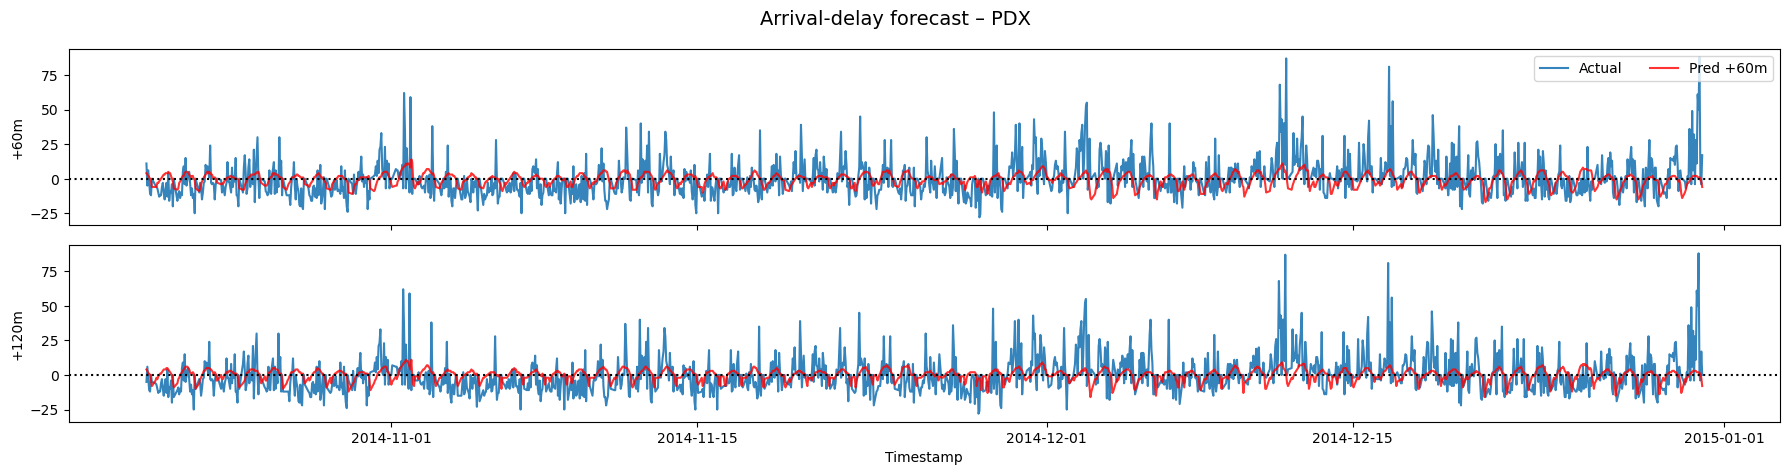

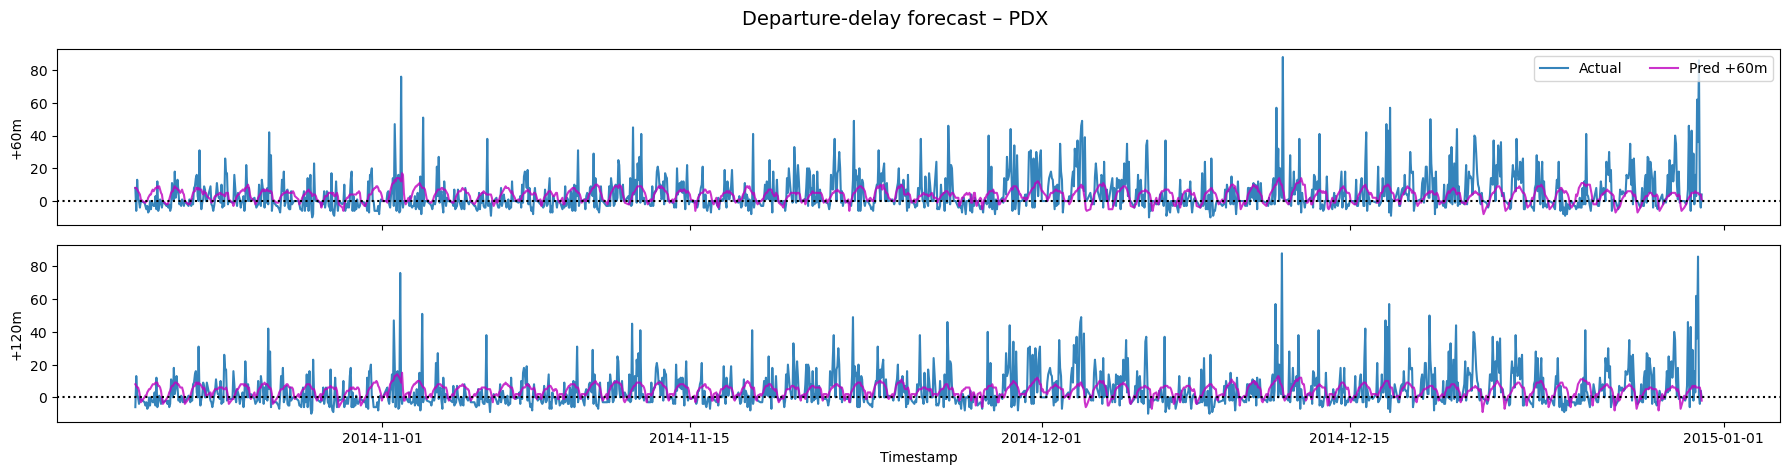

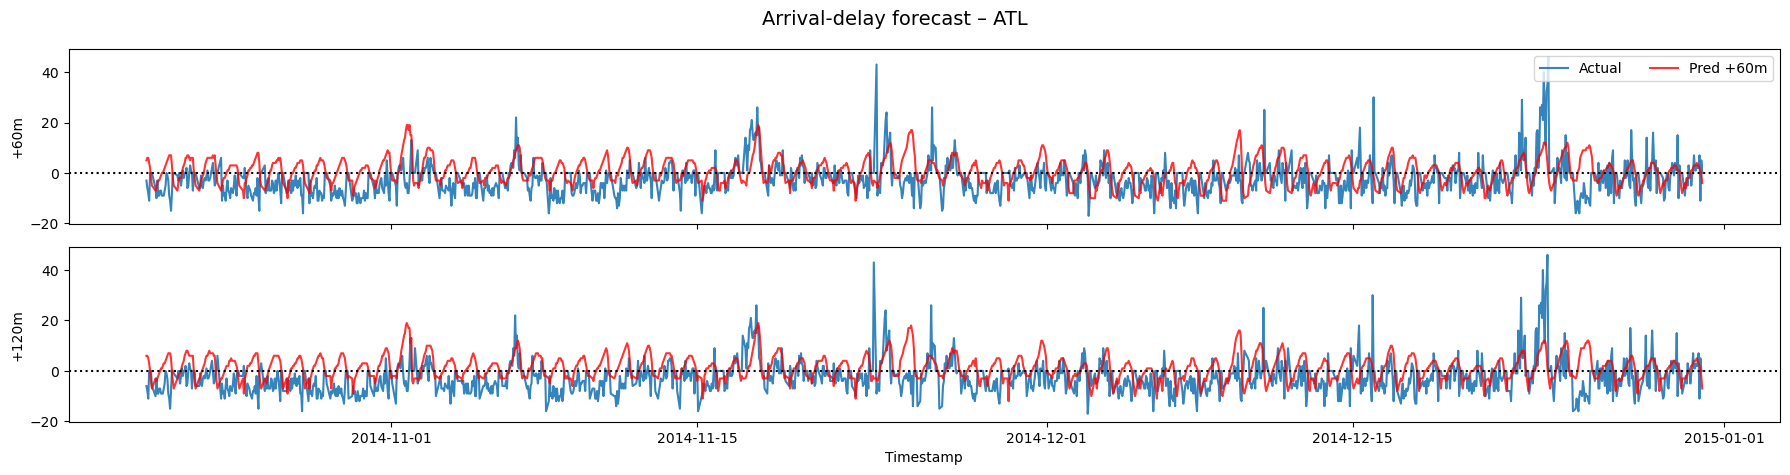

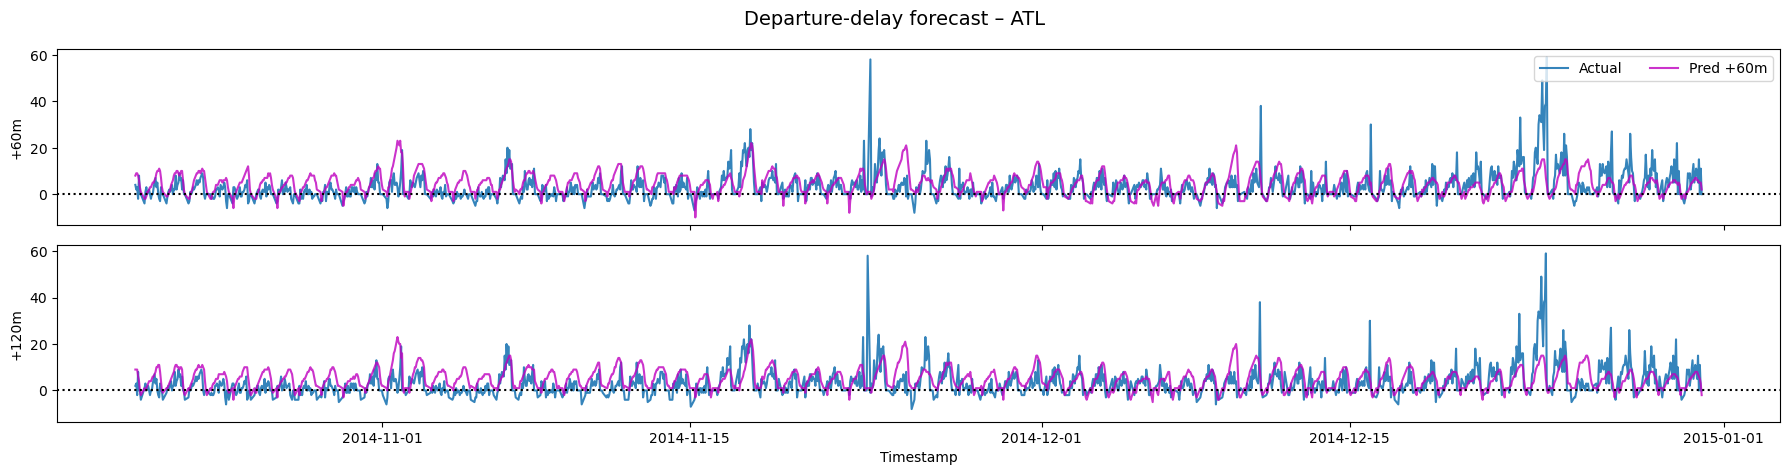

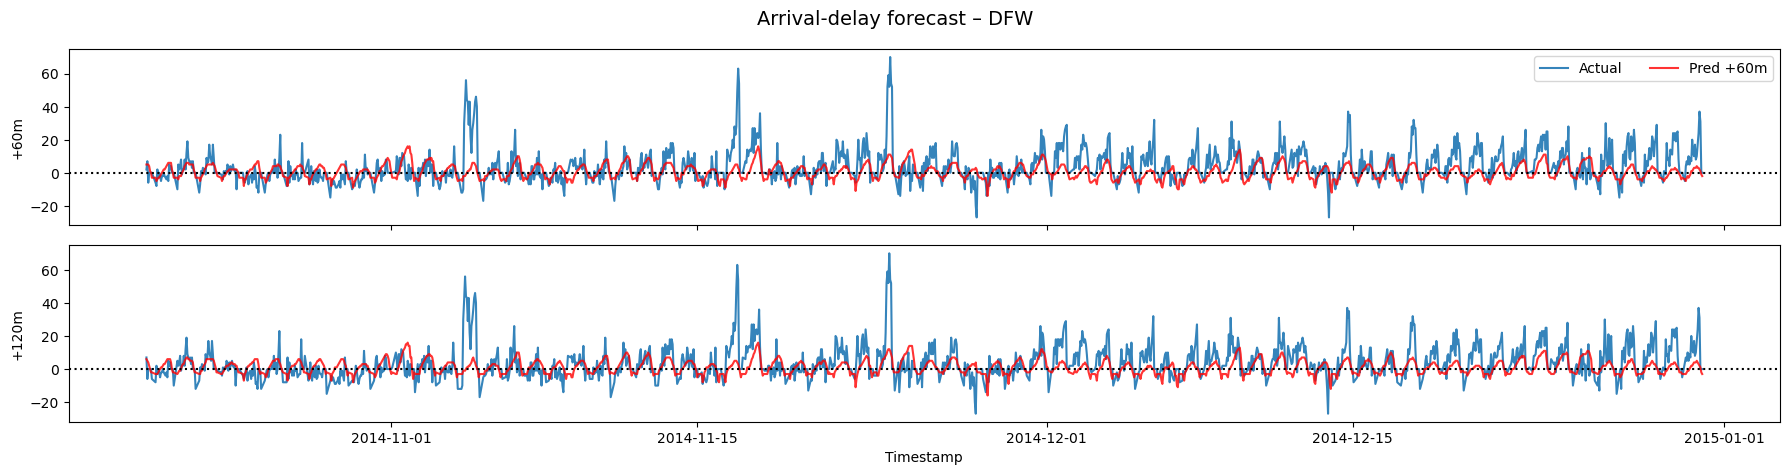

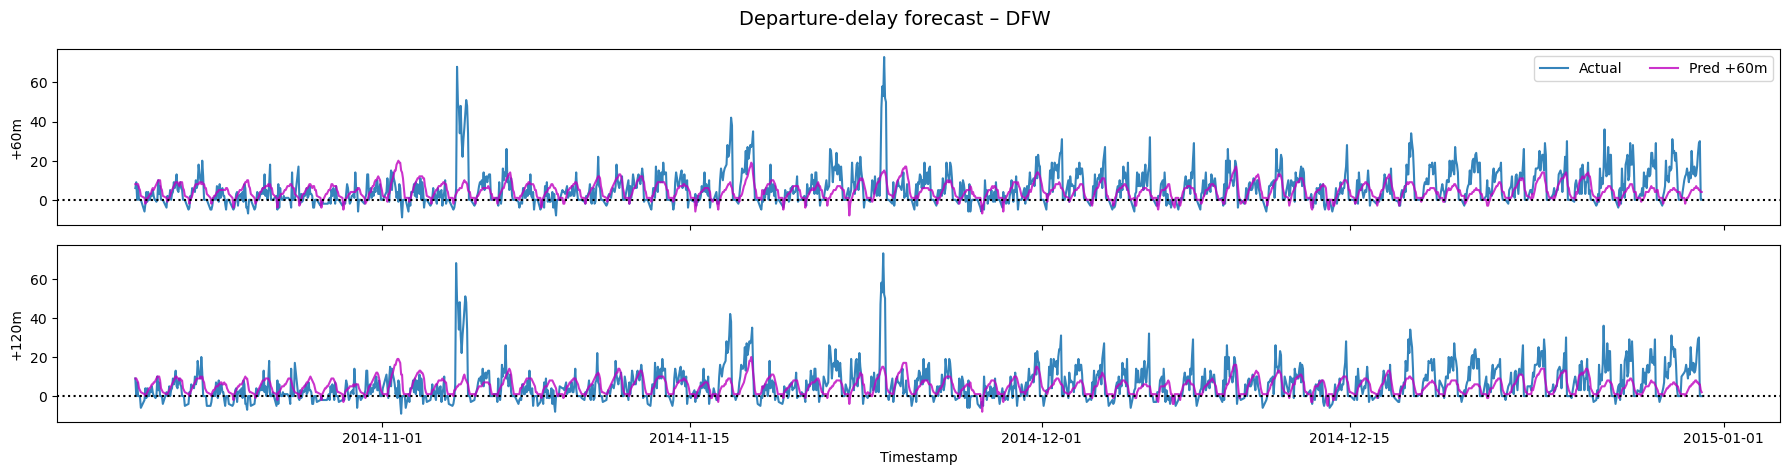

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ───────────────────────── prep ─────────────────────────
buffers   = []
windows   = y_pred.shape[0]
rows_idx  = np.arange(lookback, lookback + windows)
H         = lookahead
horiz_cols = [f"{60*(h+1)}m" for h in range(H)]

# y_true has shape [windows (=B), lookahead (=H), N, D]
windows, H, N, D = y_true.shape

# count valid (non–zero) entries per airport across *all* windows & horizons
valid_mask   = (y_true[..., 0] != 0.0)          # shape [B, H, N]
counts_per_n = valid_mask.sum(axis=(0, 1))      # shape [N]

top5_idx     = counts_per_n.argsort()[::-1][:10]
top5         = [airports[i] for i in top5_idx]
print("Top-5 airports:", top5)

# 2)  combine ARR & DEP for those airports
for node, ap in enumerate(airports):
    if ap not in top5:
        continue

    times     = [test_bins[t] for t in rows_idx]
    arr_true  = np.stack([Y_test[rows_idx + h, node, 0] for h in range(H)], axis=1)
    dep_true  = np.stack([Y_test[rows_idx + h, node, 1] for h in range(H)], axis=1)
    arr_pred  = y_pred[:, :H, node, 0]
    dep_pred  = y_pred[:, :H, node, 1]

    df_ap = pd.concat(
        [
            pd.Series(times, name="time"),
            pd.DataFrame(arr_true.round().astype(int), columns=[f"arr_{c}"     for c in horiz_cols]),
            pd.DataFrame(dep_true.round().astype(int), columns=[f"dep_{c}"     for c in horiz_cols]),
            pd.DataFrame(arr_pred.round().astype(int), columns=[f"arr_est_{c}" for c in horiz_cols]),
            pd.DataFrame(dep_pred.round().astype(int), columns=[f"dep_est_{c}" for c in horiz_cols])
        ],
        axis=1
    ).assign(airport=ap)

    buffers.append(df_ap)

results = pd.concat(buffers, ignore_index=True)
print("results.shape =", results.shape)

# ───────────────────────── plot ─────────────────────────
for airport in top5:
    df = results.query('airport == @airport').reset_index(drop=True)

    # -------- Arrival figure --------
    fig_a, axes_a = plt.subplots(H, 1, figsize=(18, 2.4*H), sharex=True, sharey=True)
    for ax, mins in zip(axes_a, [60*(h+1) for h in range(H)]):
        ax.plot(df["time"], df[f"arr_{mins}m"],        label="Actual", alpha=0.9)
        ax.plot(df["time"], df[f"arr_est_{mins}m"], 'r', label=f"Pred +{mins}m", alpha=0.8)
        ax.axhline(0, ls=":", color="k")
        if mins == 60: ax.legend(ncol=2, loc="upper right")
        ax.set_ylabel(f"+{mins}m")
    axes_a[-1].set_xlabel("Timestamp")
    fig_a.suptitle(f"Arrival-delay forecast – {airport}", fontsize=14)
    plt.tight_layout(); plt.show()

    # -------- Departure figure --------
    fig_d, axes_d = plt.subplots(H, 1, figsize=(18, 2.4*H), sharex=True, sharey=True)
    for ax, mins in zip(axes_d, [60*(h+1) for h in range(H)]):
        ax.plot(df["time"], df[f"dep_{mins}m"],        label="Actual", alpha=0.9)
        ax.plot(df["time"], df[f"dep_est_{mins}m"], 'm', label=f"Pred +{mins}m", alpha=0.8)
        ax.axhline(0, ls=":", color="k")
        if mins == 60: ax.legend(ncol=2, loc="upper right")
        ax.set_ylabel(f"+{mins}m")
    axes_d[-1].set_xlabel("Timestamp")
    fig_d.suptitle(f"Departure-delay forecast – {airport}", fontsize=14)
    plt.tight_layout(); plt.show()
